# CareerVillage Questions Recommendation
> developing a method to recommend relevant questions to the professionals who are most likely to answer them

- toc: true
- badges: true
- comments: true
- categories: [TopicModel, LDA, Visualization, Education]
- author: "<a href='https://www.kaggle.com/danielbecker/careervillage-org-recommendation-engine'>Daniel Becker</a>"
- image:

## Introduction
[CareerVillage.org](http://careervillage.org/) is a nonprofit that crowdsources career advice for underserved youth. The platform uses a Q&A style similar to *StackOverflow* or *Quora* to provide students with answers to any question about any career. 

To date, 25K+ volunteers have created profiles and opted in to receive emails when a career question is a good fit for them. To help students get the advice they need, the team at [CareerVillage.org](http://careervillage.org/) needs to be able to send the right questions to the right volunteers. The notifications sent to volunteers seem to have the greatest impact on how many questions are answered.

**Objective**: develop a method to recommend relevant questions to the professionals who are most likely to answer them.

## Environment Setup

In [ ]:
# !pip install -q pyLDAvis

In [ ]:
import os
import re
import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import networkx as nx

from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load('en')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
#nlp.remove_pipe('tagger')

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

seed = 13
random.seed(seed)
np.random.seed(seed)

%reload_ext google.colab.data_table

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -h -iv

re        : 2.2.1
IPython   : 5.5.0
spacy     : 2.2.4
matplotlib: 3.2.2
numpy     : 1.21.0
gensim    : 3.6.0
networkx  : 2.5.1
pyLDAvis  : 3.3.1
pandas    : 1.3.0



## Data Loading

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c data-science-for-good-careervillage

In [ ]:
!unzip /content/data-science-for-good-careervillage.zip

In [ ]:
professionals = pd.read_csv('professionals.csv')
groups = pd.read_csv('groups.csv')
comments = pd.read_csv('comments.csv')
school_memberships = pd.read_csv('school_memberships.csv')
tags = pd.read_csv('tags.csv')
emails = pd.read_csv('emails.csv')
group_memberships = pd.read_csv('group_memberships.csv')
answers = pd.read_csv('answers.csv')
students = pd.read_csv('students.csv')
matches = pd.read_csv('matches.csv')
questions = pd.read_csv('questions.csv')
tag_users = pd.read_csv('tag_users.csv')
tag_questions = pd.read_csv('tag_questions.csv')
answer_scores = pd.read_csv('answer_scores.csv')
question_scores = pd.read_csv('question_scores.csv')

In [ ]:
professionals.head()

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,2011-10-05 20:35:19 UTC+0000
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,2011-10-05 20:49:21 UTC+0000
2,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",NaN,NaN,2011-10-18 17:31:26 UTC+0000
3,977428d851b24183b223be0eb8619a8c,"Boston, Massachusetts",NaN,NaN,2011-11-09 20:39:29 UTC+0000
4,e2d57e5041a44f489288397c9904c2b2,NaN,NaN,NaN,2011-12-10 22:14:44 UTC+0000


In [ ]:
groups.head()

,groups_id,groups_group_type
0,eabbdf4029734c848a9da20779637d03,youth program
1,7080bf8dcf78463bb03e6863887fd715,youth program
2,bc6fc50a2b444efc8ec47111b290ffb8,youth program
3,37f002e8d5e442ca8e36e972eaa55882,youth program
4,52419ff84d4b47bebd0b0a6c1263c296,youth program


In [ ]:
comments.head(2)

,comments_id,comments_author_id,comments_parent_content_id,comments_date_added,comments_body
0,f30250d3c2ca489db1afa9b95d481e08,9fc88a7c3323466dbb35798264c7d497,b476f9c6d9cd4c50a7bacdd90edd015a,2019-01-31 23:39:40 UTC+0000,"First, you speak to recruiters. They are train..."
1,ca9bfc4ba9464ea383a8b080301ad72c,de2415064b9b445c8717425ed70fd99a,ef4b6ae24d1f4c3b977731e8189c7fd7,2019-01-31 20:30:47 UTC+0000,Most large universities offer study abroad pro...


In [ ]:
school_memberships.head()

,school_memberships_school_id,school_memberships_user_id
0,197406,23dce13ca6164a73aec7a3cd56a4884d
1,197398,23dce13ca6164a73aec7a3cd56a4884d
2,199821,23dce13ca6164a73aec7a3cd56a4884d
3,186239,9c5803ae43ca4cf6b27ea85871625116
4,182063,9c5803ae43ca4cf6b27ea85871625116


In [ ]:
tags.head()

,tags_tag_id,tags_tag_name
0,27490,college
1,461,computer-science
2,593,computer-software
3,27292,business
4,18217,doctor


In [ ]:
emails.head()

,emails_id,emails_recipient_id,emails_date_sent,emails_frequency_level
0,2337714,0c673e046d824ec0ad0ebe012a0673e4,2018-12-07 01:05:40 UTC+0000,email_notification_daily
1,2336077,0c673e046d824ec0ad0ebe012a0673e4,2018-12-06 01:14:15 UTC+0000,email_notification_daily
2,2314660,0c673e046d824ec0ad0ebe012a0673e4,2018-11-17 00:38:27 UTC+0000,email_notification_daily
3,2312639,0c673e046d824ec0ad0ebe012a0673e4,2018-11-16 00:32:19 UTC+0000,email_notification_daily
4,2299700,0c673e046d824ec0ad0ebe012a0673e4,2018-11-08 00:16:40 UTC+0000,email_notification_daily


In [ ]:
answers.head(2)

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14 UTC+0000,<p>Hi!</p>\n<p>You are asking a very interesti...
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08 UTC+0000,<p>Hi. I joined the Army after I attended coll...


## Feature Extraction

The token_pos is used in spacy to extract only words belonging to the part-of-speech (POS) tagging. With this we want to reduce the text to only relevant words. A description of all available POS tags can be read at https://spacy.io/api/annotation#pos-tagging

In [ ]:
# Spacy Tokenfilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

The actual_date should simulate the current date, because we only have data until 2019-01-31 end of the day.

In [ ]:
professionals.dtypes

professionals_id             object
professionals_location       object
professionals_industry       object
professionals_headline       object
professionals_date_joined    object
dtype: object

In [ ]:
# The data export was from 1. February 2019. For Production use datetime.now()
actual_date = datetime(2019, 2 ,1)

In [ ]:
def nlp_preprocessing(data):
    """ Use NLP to transform the text corpus to cleaned sentences and word tokens

        param data: List with sentences, which should be processed.
        return processed_tokens: List with the cleaned and tokenized sentences
    """    
    def token_filter(token):
        """ Keep tokens which are alphabetic, in the pos (part-of-speech) list and not in stop list
            
        """    
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    data = [re.compile(r'<[^>]+>').sub('', x) for x in data] #Remove HTML-tags
    processed_tokens = []
    data_pipe = nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(filtered_tokens)
    return processed_tokens

### Features
First we transform the datetime columns (`date_added` and `date_joined`), so that we can work with time delta functions.  
After this we create the following new columns:  

**DataFrame Questions:**  
* **questions_full_text:** Merge the questions title with the body for later use of NLP.  
* **questions_answers_count:** How many answers a question has.  
* **questions_first_answers:** The timestamp for the first answer of the question.  
* **questions_last_answers:** The timestamp for the last answer of the question.  
* **questions_hearts:** Hearts score for the question.  
* **questions_tags:** List with tags for the question.  
* **nlp_tokens:** Extract relevant tokens from the question full text.  

**DataFrame Answers:**  
* **time_delta_answert:** Time delta from question to answer.  
* **answers_time_rank:** Ranking for time to answer the question.  
* **answers_hearts:** Hearts score for the answer.

**DataFrame Professionals:**  
* **professionals_time_delta_joined:** Time since creating the account.  
* **professionals_answers_count:** Number of written answers.  
* **professionals_comments_count:** Number of written comments.  
* **date_last_answer:** Date last answer.  
* **date_first_answer:** Date first answer.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (answer or comment).  
* **date_first_activity:** Date first activity (answer or comment).  
* **professional_answers_hearts:** Hearts score for all answers. 
* **professional_tags:** List with tags for the professional.  

**DataFrame Students:**  
* **students_time_delta_joined:** Time since creating the account.  
* **students_questions_count:** Number of written questions.  
* **students_comments_count:** Number of written comments.  
* **date_last_questions:** Date last question.  
* **date_first_questions:** Date first question.  
* **date_last_comment:** Date last comment.  
* **date_first_comment:** Date first comment.  
* **date_last_activity:** Date last activity (question or comment).  
* **date_first_activity:** Date first activity (question or comment).  
* **students_questions_hearts:** Hearts score for all questions.  
* **students_tags:** List with tags for the students.  

**New DataFrame emails_response:**  
Has the response activity from professionals to emails and additional informations about the questions behind.
* **time_delta_email_answer:** Time needed the question was answered after the email was send.  
* **time_delta_question_email:** Time needed the email was send after the questions was written.

In [ ]:
# Transform datetime datatypes
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)

In [ ]:
students.dtypes

students_id                          object
students_location                    object
students_date_joined    datetime64[ns, UTC]
dtype: object

In [ ]:
df_list = [professionals, groups, comments, school_memberships, tags, emails,
           group_memberships, answers, students, matches, questions, tag_users,
           tag_questions, answer_scores, question_scores]

for _df in df_list:
  for col, dtype in zip(_df.columns, _df.dtypes):
    if str(dtype) == "datetime64[ns, UTC]":
      print(str(col) +" => "+ str(dtype))
      _df[col] = _df[col].dt.tz_localize(None)

professionals_date_joined => datetime64[ns, UTC]
comments_date_added => datetime64[ns, UTC]
emails_date_sent => datetime64[ns, UTC]
answers_date_added => datetime64[ns, UTC]
students_date_joined => datetime64[ns, UTC]
questions_date_added => datetime64[ns, UTC]


In [ ]:
### Questions
# Merge Question Title and Body
questions['questions_full_text'] = questions['questions_title'] +'\r\n\r\n'+ questions['questions_body']
# Count of answers
temp = answers.groupby('answers_question_id').size()
questions['questions_answers_count'] = pd.merge(questions, pd.DataFrame(temp.rename('count')), left_on='questions_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# First answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
questions['questions_first_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']
# Last answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').max()
questions['questions_last_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']
# Hearts Score
temp = pd.merge(questions, question_scores, left_on='questions_id', right_on='id', how='left')
questions['questions_hearts'] = temp['score'].fillna(0).astype(int)
# Questions Tags list
temp = pd.merge(questions, tag_questions, left_on='questions_id', right_on='tag_questions_question_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('questions_id')['tags_tag_name'].apply(list).rename('questions_tags')
questions['questions_tags'] = pd.merge(questions, temp.to_frame(), left_on='questions_id', right_index=True, how='left')['questions_tags']
# Get NLP Tokens
questions['nlp_tokens'] = nlp_preprocessing(questions['questions_full_text'])

In [ ]:
### Answers
# Days required to answer the question
temp = pd.merge(questions, answers, left_on='questions_id', right_on='answers_question_id')
answers['time_delta_answer'] = (temp['answers_date_added'] - temp['questions_date_added'])
# Ranking for answers time
answers['answers_time_rank'] = answers.groupby('answers_question_id')['time_delta_answer'].rank(method='min').astype(int)
# Hearts Score
temp = pd.merge(answers, answer_scores, left_on='answers_id', right_on='id', how='left')
answers['answers_hearts'] = temp['score'].fillna(0).astype(int)

In [ ]:
### Professionals
# Time since joining
professionals['professionals_time_delta_joined'] = actual_date - professionals['professionals_date_joined']
# Number of answers
temp = answers.groupby('answers_author_id').size()
professionals['professionals_answers_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Number of comments
temp = comments.groupby('comments_author_id').size()
professionals['professionals_comments_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Last activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)
# First activity (Total)
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)
# Total Hearts score
temp = answers.groupby('answers_author_id')['answers_hearts'].sum()
professionals['professional_answers_hearts'] = pd.merge(professionals, pd.DataFrame(temp.rename('answers_hearts')), left_on='professionals_id', right_index=True, how='left')['answers_hearts'].fillna(0).astype(int)
# Professionals Tags to List
temp = pd.merge(professionals, tag_users, left_on='professionals_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('professionals_id')['tags_tag_name'].apply(list).rename('professionals_tags')
professionals['professionals_tags'] = pd.merge(professionals, temp.to_frame(), left_on='professionals_id', right_index=True, how='left')['professionals_tags']

In [ ]:
### Students
# Time since joining
students['students_time_delta_joined'] = actual_date - students['students_date_joined']
# Number of answers
temp = questions.groupby('questions_author_id').size()
students['students_questions_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Number of comments
temp = comments.groupby('comments_author_id').size()
students['students_comments_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)
# Total Hearts score
temp = questions.groupby('questions_author_id')['questions_hearts'].sum()
students['students_questions_hearts'] = pd.merge(students, pd.DataFrame(temp.rename('questions_hearts')), left_on='students_id', right_index=True, how='left')['questions_hearts'].fillna(0).astype(int)
# Students Tags to List
temp = pd.merge(students, tag_users, left_on='students_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('students_id')['tags_tag_name'].apply(list).rename('students_tags')
students['students_tags'] = pd.merge(students, temp.to_frame(), left_on='students_id', right_index=True, how='left')['students_tags']

In [ ]:
### Emails Response
emails_response = pd.merge(emails, matches, left_on='emails_id', right_on='matches_email_id', how='inner')
emails_response = pd.merge(emails_response, questions, left_on='matches_question_id', right_on='questions_id', how='inner')
emails_response = pd.merge(emails_response, answers, left_on=['emails_recipient_id', 'matches_question_id'], right_on=['answers_author_id', 'answers_question_id'], how='left')
emails_response = emails_response.drop(['matches_email_id', 'matches_question_id', 'answers_id', 'answers_author_id', 'answers_body', 'answers_question_id'], axis=1)
emails_response = emails_response.drop(['questions_author_id', 'questions_title', 'questions_body', 'questions_full_text'], axis=1)
emails_response['time_delta_email_answer'] = (emails_response['answers_date_added'] - emails_response['emails_date_sent'])
emails_response['time_delta_question_email'] = (emails_response['emails_date_sent'] - emails_response['questions_date_added'])

## EDA

### How do the files connect
Present how the data connects using Graphviz

In [ ]:
from graphviz import Digraph, Source

g = Digraph('G', filename='process.gv', engine='sfdp')

g.edge('Answers', 'Professionals')
g.edge('Questions', 'Answers')
g.edge('Question Score', 'Questions')
g.edge('Answer Score', 'Answers')
g.edge('Emails', 'Answers')
g.edge('Emails', 'Matches')
g.edge('Answers', 'Comments')
g.edge('Questions', 'Comments')
g.edge('Questions', 'Question Tags')
g.edge('Students', 'Group Memberships')
g.edge('Students', 'School Memberships')
g.edge('Tag Users', 'Group Memberships')
g.edge('Tag Users', 'Tags')
g.edge('Tag Questions', 'Tags')
g.edge('Questions', 'Tag Questions')
g.edge('Group Memberships', 'Groups')
g.edge('Matches', 'Questions')

s = Source(g, filename="data_flow", format="png")
s.view()

'data_flow.png'

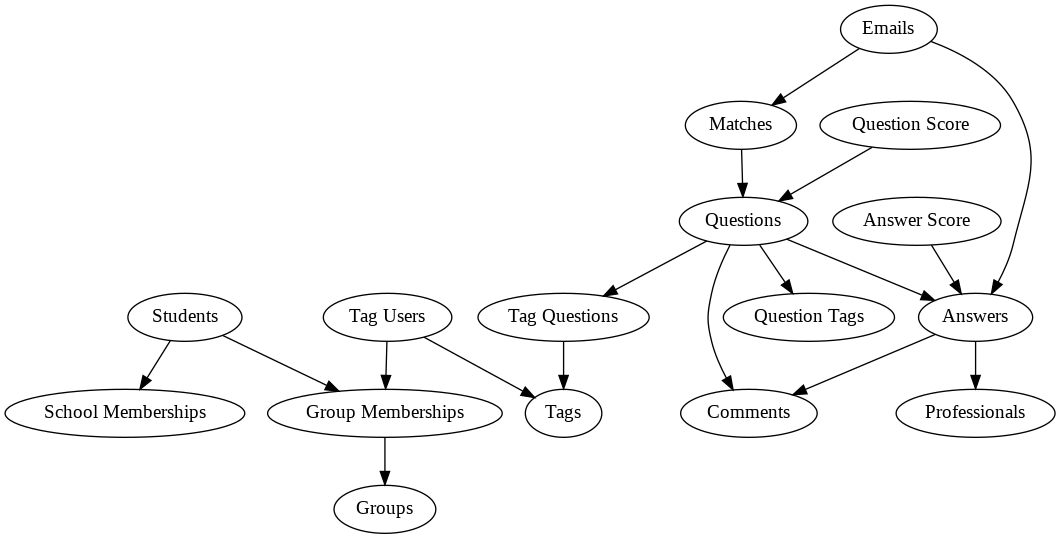

In [ ]:
from IPython.display import display, Image
display(Image(filename='data_flow.png'))

### Time Series 
Here we can see in which year the most user activity was. There was a large increase in 2016. 40% of all questions and comments were in this year. Most of the professionals (40%) have joined in the year 2018. But this hasn't increase the number of answers and comments.
In some future analyses, we will limit the data to 2016 and onwards. This is to prevent possible noise from the Career Village start time.

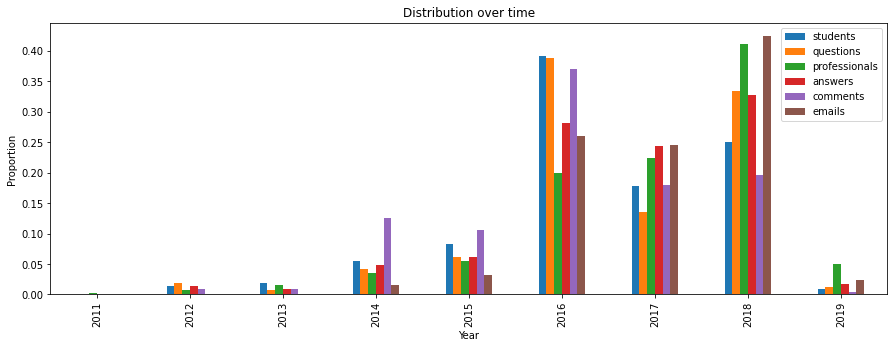

In [ ]:
plt_professionals = (professionals.groupby([professionals['professionals_date_joined'].dt.year]).size()/len(professionals.index))
plt_students = (students.groupby([students['students_date_joined'].dt.year]).size()/len(students.index))
plt_questions = (questions.groupby([questions['questions_date_added'].dt.year]).size()/len(questions.index))
plt_answers = (answers.groupby([answers['answers_date_added'].dt.year]).size()/len(answers.index))
plt_emails = (emails.groupby([emails['emails_date_sent'].dt.year]).size()/len(emails.index))
plt_comments = (comments.groupby([comments['comments_date_added'].dt.year]).size()/len(comments.index))
plt_data = pd.DataFrame({'students':plt_students,
                         'questions': plt_questions,
                         'professionals':plt_professionals,
                        'answers':plt_answers,
                        'comments':plt_comments,
                        'emails':plt_emails})
plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Distribution over time')
plt.show()

### Missing values (Professionals) 
The Location, Industry and Headline were specified by the most professionals. Even hashtags are used by most. The specification of the school is made however only by the fewest.
The industry could therefore be a good feature for the recommendation. Especially for new authors who have not written any answer or comments. If an professional is in the medical field, he should not necessarily get questions about a career as a lawyer.

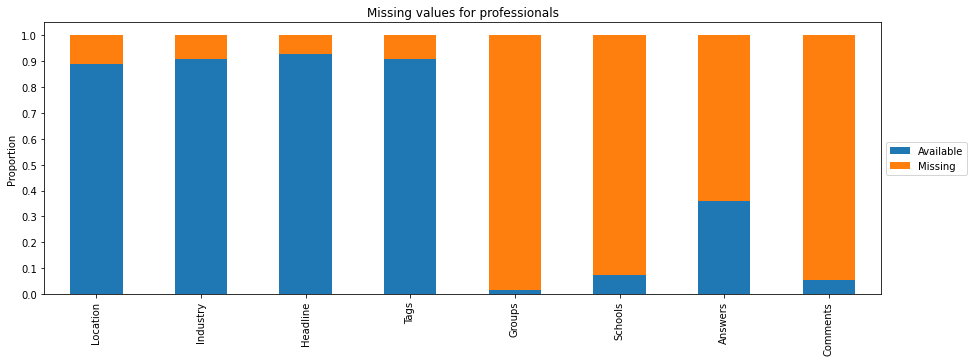

,Available,Missing
Location,0.889955,0.110045
Industry,0.908497,0.091503
Headline,0.926577,0.073423
Tags,0.909136,0.090864
Groups,0.017477,0.982523
Schools,0.075341,0.924659
Answers,0.357594,0.642406
Comments,0.052359,0.947641


In [ ]:
temp = professionals[['professionals_location', 'professionals_industry', 'professionals_headline']].fillna('Missing')
temp = temp.applymap(lambda x: x if x == 'Missing' else 'Available')
plt_professionals_location = temp.groupby('professionals_location').size()/len(temp.index)
plt_professionals_industry = temp.groupby('professionals_industry').size()/len(temp.index)
plt_professionals_headline = temp.groupby('professionals_headline').size()/len(temp.index)

plt_professionals_tags = tag_users['tag_users_user_id'].unique()
plt_professionals_tags = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_tags else 'Missing').rename('professionals_tags')
plt_professionals_tags = plt_professionals_tags.groupby(plt_professionals_tags).size()/len(plt_professionals_tags.index)
plt_professionals_group = group_memberships['group_memberships_user_id'].unique()
plt_professionals_group = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_group else 'Missing').rename('professionals_groups')
plt_professionals_group = plt_professionals_group.groupby(plt_professionals_group).size()/len(plt_professionals_group.index)
plt_professionals_school = school_memberships['school_memberships_user_id'].unique()
plt_professionals_school = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_school else 'Missing').rename('professionals_schools')
plt_professionals_school = plt_professionals_school.groupby(plt_professionals_school).size()/len(plt_professionals_school.index)

temp = professionals[['professionals_answers_count', 'professionals_comments_count']]
temp = temp.applymap(lambda x: 'Available' if x > 0 else 'Missing')
plt_professionals_answers = temp.groupby('professionals_answers_count').size()/len(temp.index)
plt_professionals_comments = temp.groupby('professionals_comments_count').size()/len(temp.index)

plt_data = pd.DataFrame({'Location': plt_professionals_location,
                        'Industry': plt_professionals_industry,
                        'Headline': plt_professionals_headline,
                        'Tags': plt_professionals_tags,
                        'Groups': plt_professionals_group,
                        'Schools': plt_professionals_school,
                        'Answers': plt_professionals_answers,
                        'Comments': plt_professionals_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for professionals')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T

### Missing values (Students) 
It's a little different with the students. Only the location is specified by most students, while the rest is rather not used.

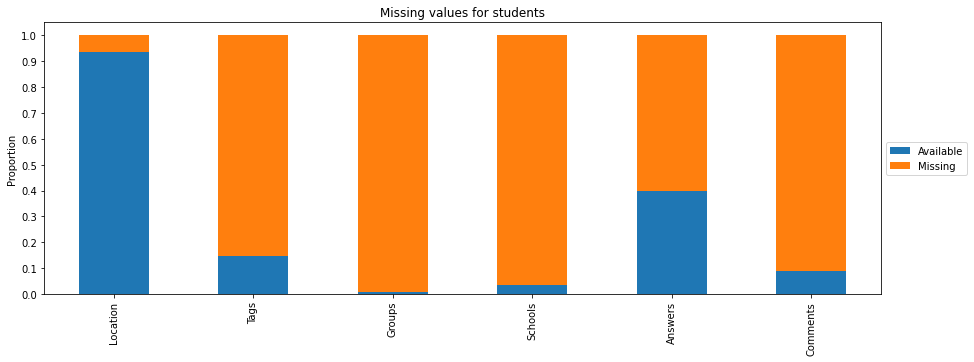

,Available,Missing
Location,0.934358,0.065642
Tags,0.148784,0.851216
Groups,0.007588,0.992412
Schools,0.034226,0.965774
Answers,0.397275,0.602725
Comments,0.087921,0.912079


In [ ]:
temp = students[['students_location']].fillna('Missing')
temp = temp.applymap(lambda x: x if x == 'Missing' else 'Available')
plt_students_location = temp.groupby('students_location').size()/len(temp.index)

plt_students_tags = tag_users['tag_users_user_id'].unique()
plt_students_tags = students['students_id'].apply(lambda x: 'Available' if x in plt_students_tags else 'Missing').rename('students_tags')
plt_students_tags = plt_students_tags.groupby(plt_students_tags).size()/len(plt_students_tags.index)
plt_students_group = group_memberships['group_memberships_user_id'].unique()
plt_students_group = students['students_id'].apply(lambda x: 'Available' if x in plt_students_group else 'Missing').rename('students_groups')
plt_students_group = plt_students_group.groupby(plt_students_group).size()/len(plt_students_group.index)
plt_students_school = school_memberships['school_memberships_user_id'].unique()
plt_students_school = students['students_id'].apply(lambda x: 'Available' if x in plt_students_school else 'Missing').rename('students_schools')
plt_students_school = plt_students_school.groupby(plt_students_school).size()/len(plt_students_school.index)

temp = students[['students_questions_count', 'students_comments_count']]
temp = temp.applymap(lambda x: 'Available' if x > 0 else 'Missing')
plt_students_questions = temp.groupby('students_questions_count').size()/len(temp.index)
plt_students_comments = temp.groupby('students_comments_count').size()/len(temp.index)

plt_data = pd.DataFrame({'Location': plt_students_location,
                        'Tags': plt_students_tags,
                        'Groups': plt_students_group,
                        'Schools': plt_students_school,
                        'Answers': plt_students_questions,
                        'Comments': plt_students_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for students')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T

### Tags matching 
The size of the bubbles depends on how many students have subscribe the tag. The x-axis is how many professionals have subscribe the tag and the y-axis is in how many questions the tag is used.

The top tag for professionals ist telecommunications on the right site with about 11% but the tag doesn't appear in many questions or students subscribtion.

The top tags for questions is college with 15.6% and carrer with 6.5%. The other top tags are carrer specific (medicine, engineering, business, ...).

The top tag for students is college but only 1.5% of the students have subscribe this tag.

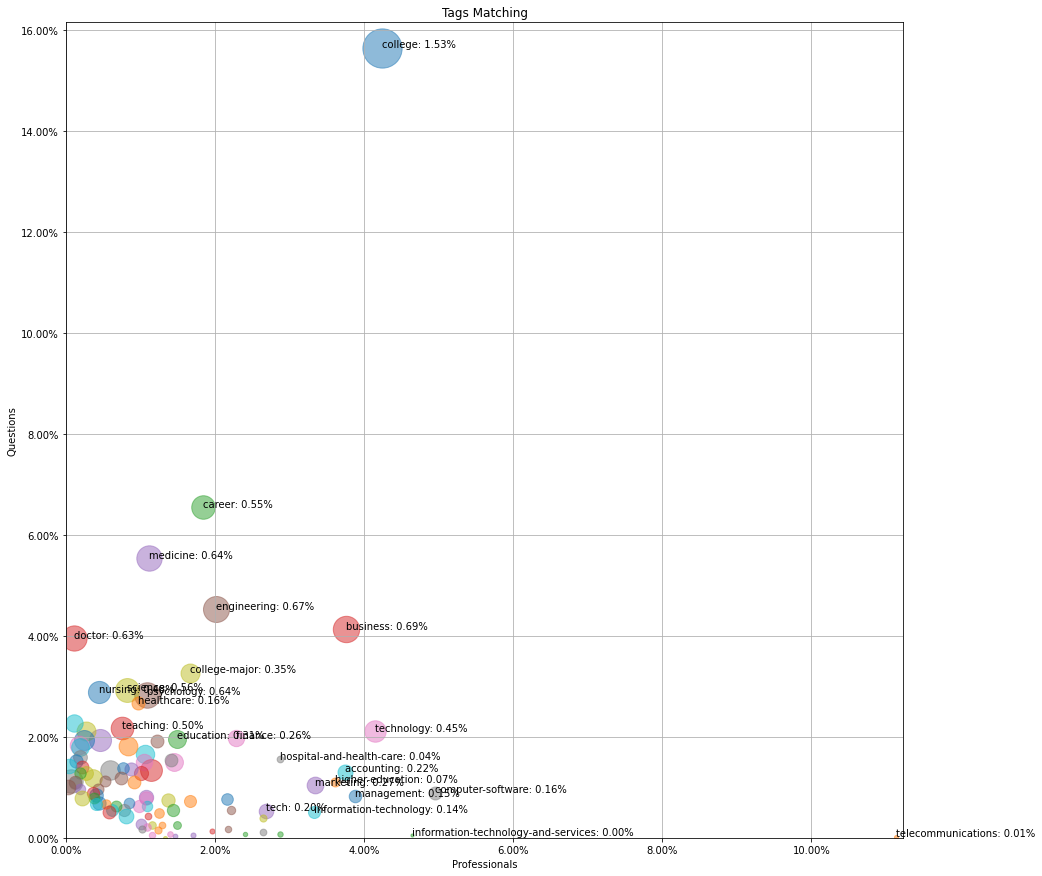

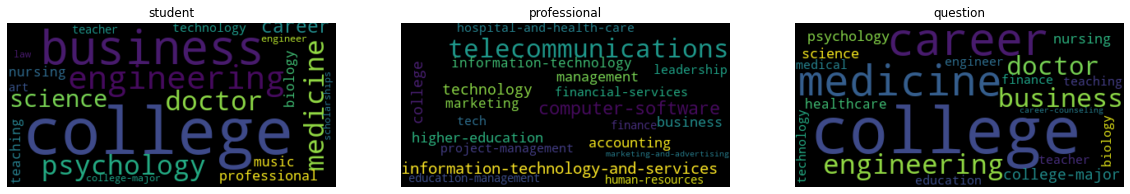

In [ ]:
students_tags = tag_users[tag_users['tag_users_user_id'].isin(students['students_id'])]
students_tags = pd.merge(students_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
students_tags['user_type'] = 'student'

professionals_tags = tag_users[tag_users['tag_users_user_id'].isin(professionals['professionals_id'])]
professionals_tags = pd.merge(professionals_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
professionals_tags['user_type'] = 'professional'

questions_tags = tag_questions
questions_tags = pd.merge(questions_tags, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
questions_tags['user_type'] = 'question'

plt_data = pd.concat([students_tags, professionals_tags, questions_tags])
plt_data = plt_data[['tags_tag_name', 'user_type']].pivot_table(index='tags_tag_name', columns='user_type', aggfunc=len, fill_value=0)
plt_data['professional'] = plt_data['professional'] / professionals.shape[0]
plt_data['student'] = plt_data['student'] / students.shape[0]
plt_data['question'] = plt_data['question'] / questions.shape[0]
plt_data['sum'] = (plt_data['professional'] + plt_data['student'] + plt_data['question'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)

# Bubble chart
fig, ax = plt.subplots(facecolor='w',figsize=(15, 15))
ax.set_xlabel('Professionals')
ax.set_ylabel('Questions')
ax.set_title('Tags Matching')
ax.set_xlim([0, max(plt_data['professional'])+0.001])
ax.set_ylim([0, max(plt_data['question'])+0.005])
import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.yaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.grid(True)
i = 0
for key, row in plt_data.iterrows():
    ax.scatter(row['professional'], row['question'], s=10+row['student']*10**5, alpha=.5)
    if i < 25:
        ax.annotate('{}: {:.2%}'.format(key, row['student']), xy=(row['professional'], row['question']))
    i += 1
plt.show()

# Wordcloud
plt.figure(figsize=(20, 20))
wordloud_values = ['student', 'professional', 'question']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=seed).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    

### First activity after registration
Here we can see how long it took, that an professional makes his first answer or a student his first question after the registration.
The most of them write the first answer/question within in the first day or haven't write any yet and use the account for other activities.

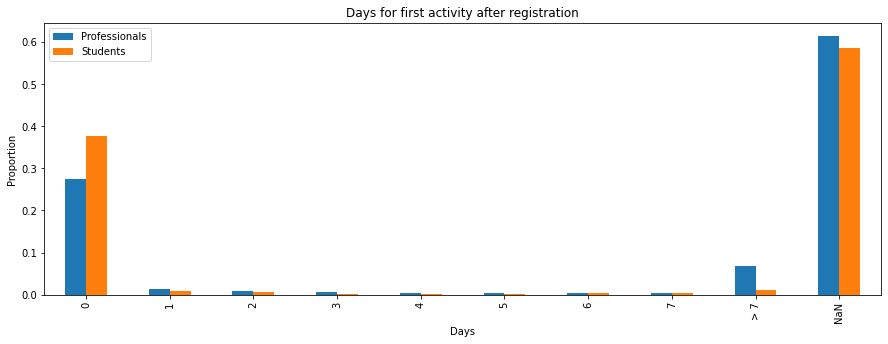

In [ ]:
plt_professionals = professionals
plt_professionals = plt_professionals[(plt_professionals['professionals_date_joined'] >= '01-01-2016') & (plt_professionals['professionals_date_joined'] <= '30-06-2018')]
plt_professionals = (plt_professionals['date_first_activity'] - plt_professionals['professionals_date_joined']).dt.days.fillna(9999).astype(int)
plt_professionals = plt_professionals.groupby(plt_professionals).size()/len(plt_professionals.index)
plt_professionals = plt_professionals.rename(lambda x: 0 if x < 0.0 else x)
plt_professionals = plt_professionals.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_professionals = plt_professionals.rename({9999:'NaN'})
plt_professionals = plt_professionals.groupby(level=0).sum()

plt_students = students
plt_students = plt_students[(plt_students['students_date_joined'] >= '01-01-2016') & (plt_students['students_date_joined'] <= '30-06-2018')]
plt_students = (plt_students['date_first_activity'] - plt_students['students_date_joined']).dt.days.fillna(9999).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Days')
plt.ylabel('Proportion')
plt.title('Days for first activity after registration')
plt.show()

### Last activity
Depending on the last comment, question or answer of a user, we have extract the last activity date. On the previously plot we have seen, that many users haven't done any activity yet. For the 'last activity' plot we take a look only on users with already have one activity (dropna).
On the cumulative histogram we can see, that in the last 12 months only 39% of professionals and 24% of students have written a comment, question or answer.
50% of the professionals haven't done any activity for 17 months.

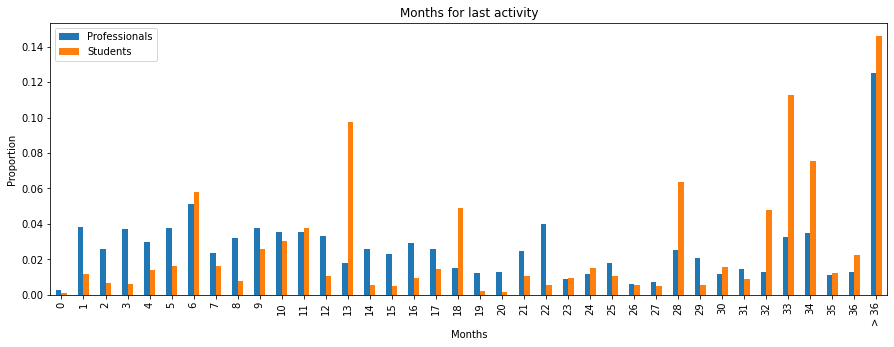

In [ ]:
plt_professionals = ((actual_date - professionals['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_professionals = plt_professionals.groupby(plt_professionals).size()/len(plt_professionals.index)
plt_professionals = plt_professionals.rename(lambda x: 0 if x < 0.0 else x)
plt_professionals = plt_professionals.rename(lambda x: x if x <= 36.0 or x == 9999 else '> 36')
plt_professionals = plt_professionals.rename({9999:'NaN'})
plt_professionals = plt_professionals.groupby(level=0).sum()

plt_students = ((actual_date - students['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 36.0 or x == 9999 else '> 36')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Months')
plt.ylabel('Proportion')
plt.title('Months for last activity')
plt.show()

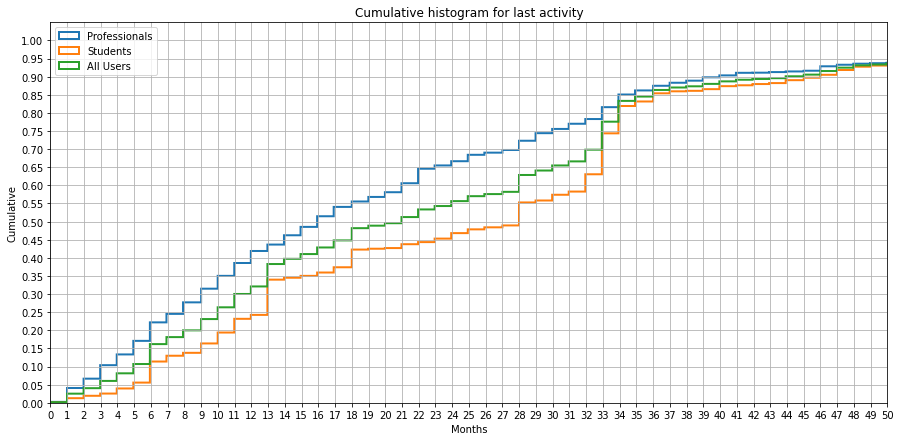

In [ ]:
plt_professionals = ((actual_date - professionals['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_students = ((actual_date - students['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_data = pd.DataFrame({'Professionals': plt_professionals, 'Students': plt_students})
plt_total = pd.concat([plt_data['Professionals'], plt_data['Students']]).rename('All Users')
plt_data.plot(kind='hist', bins=1000, density=True, histtype='step', cumulative=True, figsize=(15, 7), lw=2, grid=True)
plt_total.plot(kind='hist', bins=1000, density=True, histtype='step', cumulative=True, figsize=(15, 7), lw=2, grid=True)
plt.xlabel('Months')
plt.ylabel('Cumulative')
plt.title('Cumulative histogram for last activity')
plt.legend(loc='upper left')
plt.xlim([0, 50])
plt.xticks(range(0, 51, 1))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

### First answer for questions
Here we can see how long it takes for a question to get the first answer.
The most questions get answered within the first two weeks. But 15% need more than 30 weeks to get there answer. And there are still some unanswered questions.
The questions are filtered until 30-06-2018 to ignore new unanswered questions.

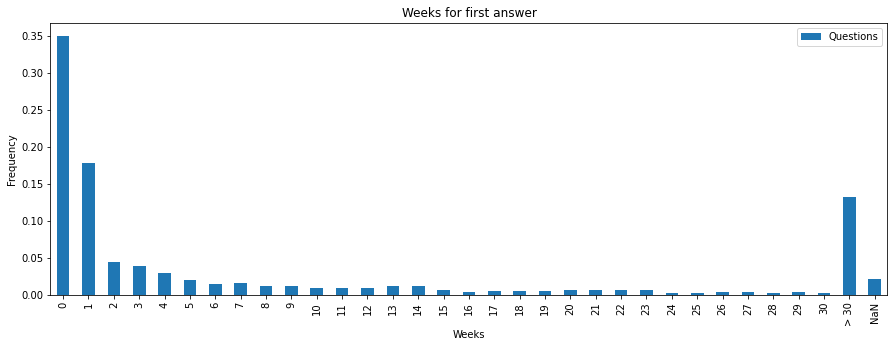

In [ ]:
plt_questions = questions
plt_questions = plt_questions[(plt_questions['questions_date_added'] >= '01-01-2016') & (plt_questions['questions_date_added'] <= '30-06-2018')]
plt_questions = ((plt_questions['questions_first_answers'] - plt_questions['questions_date_added']).dt.days/7).fillna(9999).apply(lambda x: math.ceil(x)).astype(int)
plt_questions = plt_questions.groupby(plt_questions).size()/len(plt_questions.index)
plt_questions = plt_questions.rename(lambda x: 0 if x < 0.0 else x)
plt_questions = plt_questions.rename(lambda x: x if x <= 30.0 or x == 9999 else '> 30')
plt_questions = plt_questions.rename({9999:'NaN'})
plt_questions = plt_questions.groupby(level=0).sum()

plt_data = pd.DataFrame({'Questions': plt_questions})
plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Weeks')
plt.ylabel('Frequency')
plt.title('Weeks for first answer')
plt.show()

### Question response time 
It is important for students to get their questions answered quickly. The goal was to get an answer within 24 hours.
The chart shows how many questions were answered in a month within the desired time.
From November 2015 to February 2016 the most questions get a answer within 24 hours. After that it drops and has stronger deviations.

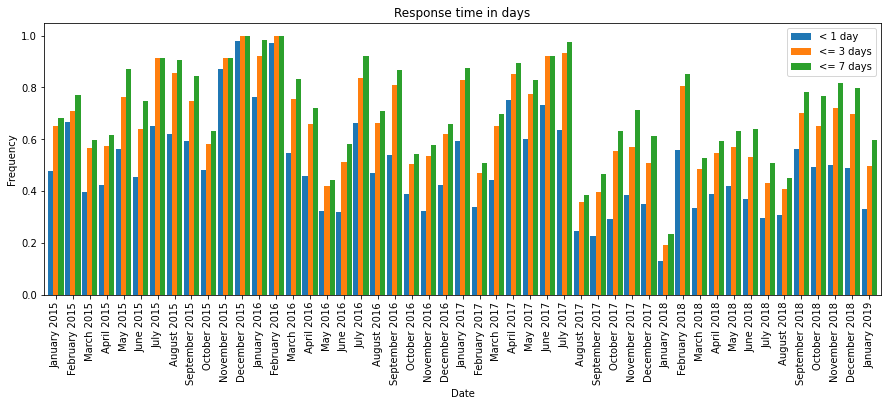

In [ ]:
plt_data = questions[['questions_date_added', 'questions_first_answers']]
plt_data = plt_data[plt_data['questions_date_added'] > '2015-01-01']
plt_data['answer_time'] = (plt_data['questions_first_answers'] - plt_data['questions_date_added'])
plt_data['days'] = (plt_data['questions_first_answers'] - plt_data['questions_date_added']).dt.days
plt_data['date'] = plt_data['questions_date_added'].dt.strftime('%B %Y')
plt_data['date'] = plt_data['date'].apply(lambda x: str(datetime.strptime(x, "%B %Y")))  
plt_data['date2'] = plt_data['questions_date_added'].dt.strftime('%B %Y')

plt_data_1 = (plt_data[plt_data['days'] <= 0].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('< 1 day')
plt_data_2 = (plt_data[plt_data['days'] <= 3].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('<= 3 days')
plt_data_3 = (plt_data[plt_data['days'] <= 7].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('<= 7 days')
plt_data = pd.concat([plt_data_1, plt_data_2, plt_data_3], axis=1).fillna(0)
plt_data.index = plt_data.index.droplevel('date')

plt_data.plot(kind='bar', figsize=(15, 5), width=0.9)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Response time in days')
plt.show()

### Email response time
The first plot shows how long it takes for professionals to answer a question after they receive an email notification of a recommended question. This is limited to emails where the specified question was also answered (dropna). When users want to answer a question from an email, they usually use the most recent email. The response time is within the first few days.

On the second plot with the response time for questions, we can see the emails focusing on older unanswered questions. the immediate emails are focusing on new questions (makes sense).

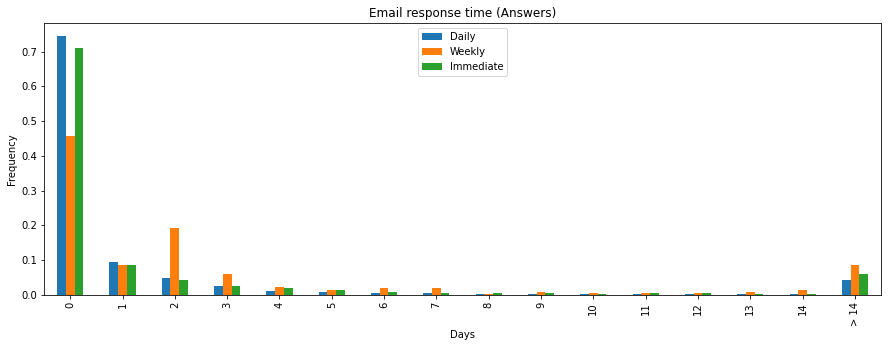

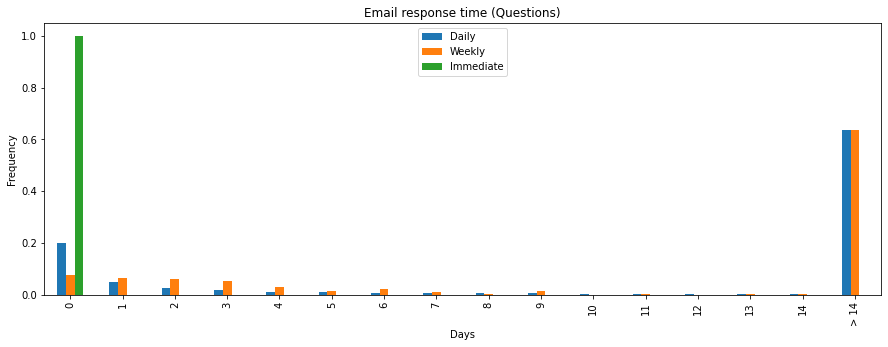

In [ ]:
plt_email_response = emails_response[(emails_response['emails_date_sent'] >= '01-01-2016')].dropna()

plt_data = pd.DataFrame()
title_mapping = {'time_delta_email_answer':'Answers', 'time_delta_question_email':'Questions'}
for qa in ['time_delta_email_answer', 'time_delta_question_email']:
    plt_data = pd.DataFrame()
    for fl in ['email_notification_daily', 'email_notification_weekly', 'email_notification_immediate']:
        temp = plt_email_response[plt_email_response['emails_frequency_level'] == fl]
        temp = temp[qa].dt.days.astype(int)
        temp = temp.groupby(temp).size()/len(temp.index)
        temp = temp.rename(lambda x: 0 if x < 0.0 else x)
        temp = temp.rename(lambda x: x if x <= 14.0 else '> 14')
        temp = temp.groupby(level=0).sum() 
        plt_data = pd.concat([plt_data, temp], axis=1, sort=False)
    plt_data.columns = ['Daily', 'Weekly', 'Immediate']

    plt_data.plot(kind='bar', figsize=(15, 5))
    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.title('Email response time ({})'.format(title_mapping[qa]))
    plt.legend(loc='upper center')
    plt.show()

### Word count 
Here we can see how many words are used for the questions and answers. A question with more text will also help to extract more important information from it, which will later be important to identify similar questions.
The professionals write very detailed answers for the students questions. We will not use the answers corpus for our recommendations but it is nice to see that the professionals write extensive answers.

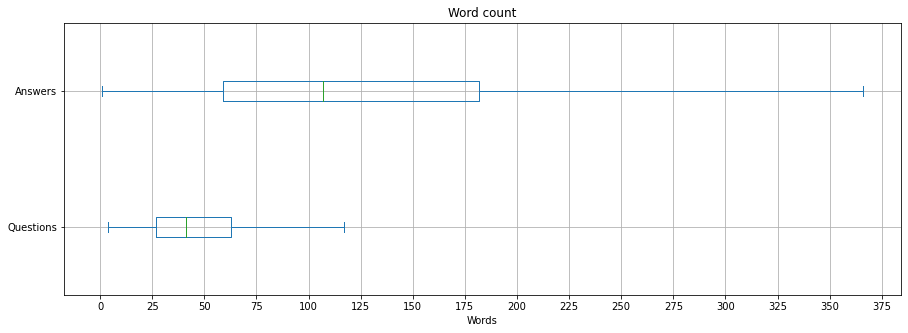

In [ ]:
plt_data_questions = questions['questions_full_text'].apply(lambda x: len(x.split())).rename("Questions")
plt_data_answers = answers['answers_body'].astype(str).apply(lambda x: len(x.split())).rename("Answers")
plt_data = pd.DataFrame([plt_data_questions, plt_data_answers]).T

plt_data.plot(kind='box', showfliers=False, vert=False, figsize=(15, 5), grid=True)
plt.xticks(range(0, 400, 25))
plt.xlabel('Words')
plt.title('Word count')
plt.show()

## Ad-hoc Analysis
The ad-hoc analysis should help to go deeper into certain issues.

### User Activities
The User Activities show us the activity timeline for a specific user. It shows when a User has registered his account and how many questions, answers and comments a user has made or how many e-mails he has receveid.

In [ ]:
def plot_user_activity(user_id, xticks_type='Month', xticks_interval=3, plot_emails=False):
    """ Merges all relevant data for a user together and builds a timeline chart.
        
        :param user_id: Index of the 'students' dataframe (default: seed)
        :param xticks_type: Grouping x axis by 'Month', 'Day' or 'Year' (default: 'Month')
        :param xticks_interval: Integer to plot every n ticks (default: 3)
        :param plot_emails: Also consider emails (default: False)
    """ 
    # student registration
    graph_student = students[students['students_id'] == user_id]
    graph_student = pd.DataFrame({'type':'Registration', 
                               'id':graph_student['students_id'], 
                               'date':graph_student['students_date_joined'],
                              'color':'green'})
    # professional registration
    graph_professional = professionals[professionals['professionals_id'] == user_id]
    graph_professional = pd.DataFrame({'type':'Registration', 
                               'id':graph_professional['professionals_id'], 
                               'date':graph_professional['professionals_date_joined'],
                              'color':'green'})
    # questions
    graph_questions = questions[questions['questions_author_id'] == user_id]
    graph_questions = pd.DataFrame({'type':'Questions',
                                   'id':graph_questions['questions_id'], 
                                   'date':graph_questions['questions_date_added'],
                                  'color':'blue'})
    # answers
    graph_answers = answers[answers['answers_author_id'] == user_id]
    graph_answers = pd.DataFrame({'type':'Answers',
                                   'id':graph_answers['answers_id'], 
                                   'date':graph_answers['answers_date_added'],
                                  'color':'red'})
    # commments
    graph_comments = comments[comments['comments_author_id'] == user_id]
    graph_comments = pd.DataFrame({'type':'Comments',
                                   'id':graph_comments['comments_id'], 
                                   'date':graph_comments['comments_date_added'],
                                  'color':'orange'})
    if plot_emails:
        graph_emails = emails[emails['emails_recipient_id'] == user_id]
        graph_emails = pd.DataFrame({'type':'Emails', 
                                   'id':graph_emails['emails_id'], 
                                   'date':graph_emails['emails_date_sent'],
                                  'color':'grey'})
    else:
        graph_emails = None

    graph_data = pd.concat([graph_student, graph_professional, graph_questions, graph_comments, graph_answers, graph_emails])
    # Group data by date
    if xticks_type=='Day':
        graph_data['date'] = graph_data['date'].dt.strftime('%Y-%m-%d')
        graph_data['date'] = graph_data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    else:
        graph_data['date'] = graph_data['date'].dt.strftime('%B %Y')
        graph_data['date'] = graph_data['date'].apply(lambda x: datetime.strptime(x, "%B %Y"))     
    
    graph_data = graph_data.groupby(['type', 'date', 'color']).size().rename('count').reset_index().sort_values('date')
    graph_data['name'] = graph_data['count'].map(str)+ ' '+graph_data['type']
    names = graph_data['name'].tolist()
    colors = graph_data['color'].tolist()
    dates = graph_data['date'].tolist()

    # Plot
    levels = np.array([-9, 9, -7, 7, -5, 5, -3, 3, -1, 1])
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create the base line
    start = min(dates)
    stop = max(dates)
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    # Create annotations
    for ii, (iname, idate, icol) in enumerate(zip(names, dates, colors)):
        level = levels[ii % len(levels)]
        vert = 'top' if level < 0 else 'bottom'
        ax.scatter(idate, 0, s=100, facecolor=icol, edgecolor='k', zorder=9999)
        ax.plot((idate, idate), (0, level), c=icol, alpha=1.0, lw=2)
        ax.text(idate, level, iname, horizontalalignment='center', verticalalignment=vert, fontsize=12, backgroundcolor=icol)
    ax.set(title="Timeline for user: {}".format(user_id))
    # Set the xticks formatting
    if xticks_type=='Month':
        ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=xticks_interval))
        ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%B %Y"))
    elif xticks_type=='Day':
        ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=xticks_interval))
        ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    elif xticks_type=='Year':
        ax.get_xaxis().set_major_locator(mdates.YearLocator())
        ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))        
    fig.autofmt_xdate()
    #Legend
    legend = []
    for index, row in graph_data[['type', 'color']].drop_duplicates().iterrows():
        legend += [mpatches.Patch(color=row['color'], label=row['type'])]
    plt.legend(handles=legend, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Remove components for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() + list(ax.spines.values())), visible=False)
    plt.show()

**Professionals**

In [ ]:
pro_sample_of_5 = professionals[professionals['professionals_answers_count']>20].sample(5)
pro_sample_of_5_ids = pro_sample_of_5.professionals_id.tolist()
pro_sample_of_5

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professionals_time_delta_joined,professionals_answers_count,professionals_comments_count,date_last_answer,date_first_answer,date_last_comment,date_first_comment,date_last_activity,date_first_activity,professional_answers_hearts,professionals_tags
7051,4dc7d9040592416f98c0bef1ad2c31f5,"Santa Clara, California",Student Services,Sr. Test Engineer at Chegg Inc.,2016-06-08 19:33:29,967 days 04:26:31,86,5,2018-05-22 06:17:56,2016-06-08 19:49:18,2018-04-16 02:18:31,2017-06-14 03:26:51,2018-05-22 06:17:56,2016-06-08 19:49:18,31,"[computer-science, computer, python, programmi..."
2515,62df4121c5d64528a7ed438b9ad86d98,"Torrance, California",Entertainment,Music Producer-Composer-Arranger-Saxophone Rec...,2015-11-04 22:38:01,1184 days 01:21:59,21,1,2017-12-01 00:51:24,2015-11-04 22:47:03,2017-12-05 06:08:48,2017-12-05 06:08:48,2017-12-05 06:08:48,2015-11-04 22:47:03,1,"[music, entertainment, music-arranging, orches..."
6514,dc28056163a8447686e5691f4c1475b0,"Southfield, Michigan",Broadcast Media,Commercial Producer at WWJTV / CW50 Detroit WKBD,2016-05-17 01:04:17,989 days 22:55:43,93,6,2018-12-07 02:38:35,2016-05-17 02:20:33,2018-10-09 01:14:34,2016-05-17 02:34:04,2018-12-07 02:38:35,2016-05-17 02:20:33,30,"[advertising, production, video-production, br..."
4588,58fa5e95fe9e480a9349bbb1d7faaddb,"Redford Charter Township, Michigan",Automotive,Mechanical Engineer I Automotive,2016-03-14 16:27:13,1053 days 07:32:47,1112,160,2019-01-13 01:21:47,2016-03-14 16:43:26,2017-09-22 00:41:00,2016-03-19 02:16:14,2019-01-13 01:21:47,2016-03-14 16:43:26,282,"[engineering, automotive, cars, mechanical-eng..."
17921,1460905b74994213b80aff1a5fab48f1,Greater Boston Area,Accounting,Assurance Associate at PwC,2018-04-04 16:13:31,302 days 07:46:29,24,0,2018-10-17 20:29:37,2018-04-04 16:29:28,NaT,NaT,2018-10-17 20:29:37,2018-04-04 16:29:28,6,"[college, accounting, college-admissions, audi..."


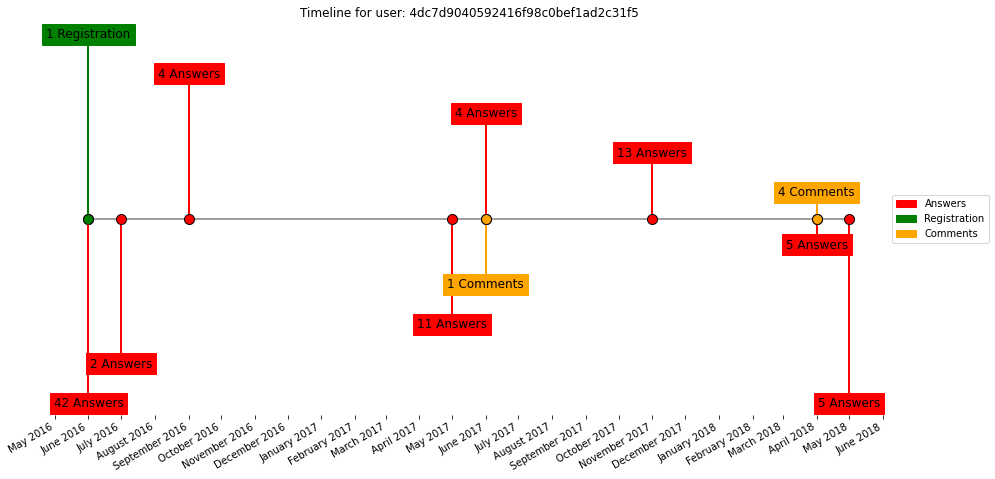

In [ ]:
user_id = pro_sample_of_5_ids[0]
plot_user_activity(user_id=user_id, xticks_type='Month', xticks_interval=1)

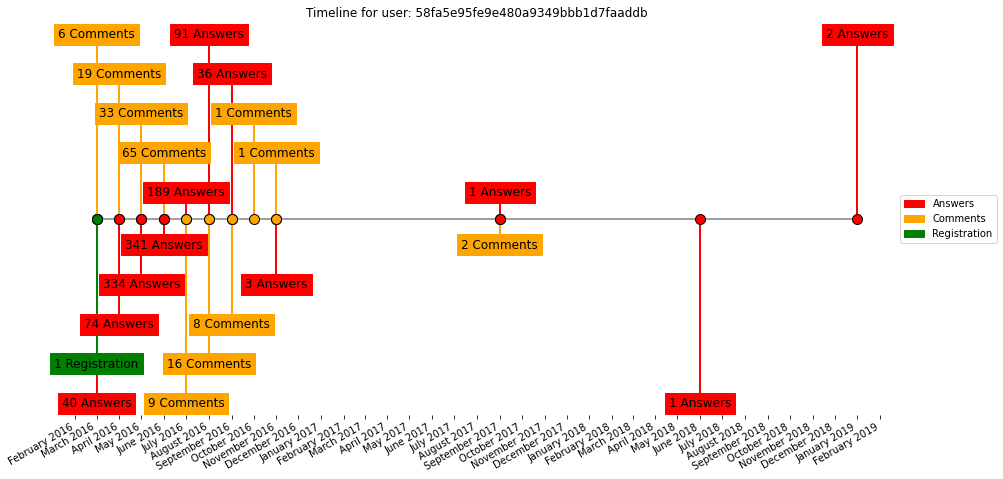

In [ ]:
user_id = pro_sample_of_5_ids[3]
plot_user_activity(user_id=user_id, xticks_type='Month', xticks_interval=1)

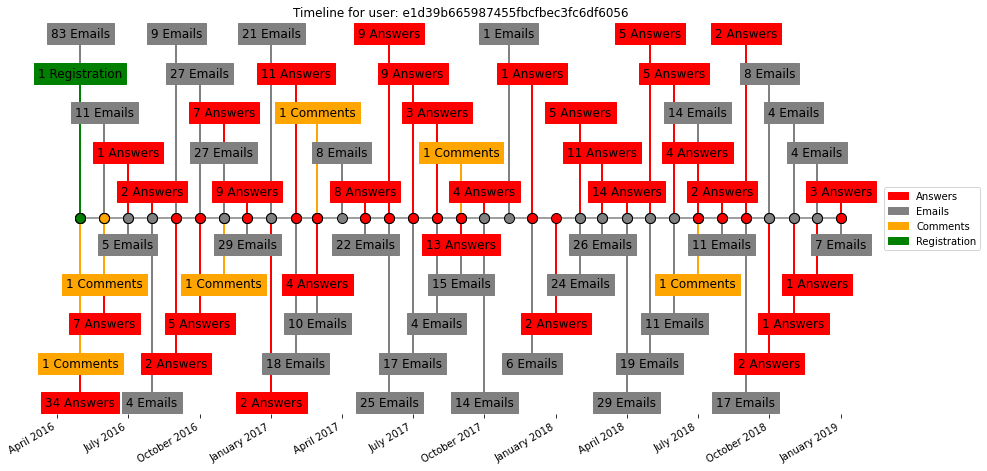

In [ ]:
user_id = 'e1d39b665987455fbcfbec3fc6df6056'
plot_user_activity(user_id=user_id, xticks_type='Month', xticks_interval=3, plot_emails=True)

**Students**

In [ ]:
stu_sample_of_5 = students[students['students_questions_count']>20].sample(5)
stu_sample_of_5_ids = stu_sample_of_5.students_id.tolist()
stu_sample_of_5

,students_id,students_location,students_date_joined,students_time_delta_joined,students_questions_count,students_comments_count,date_last_question,date_first_question,date_last_comment,date_first_comment,date_last_activity,date_first_activity,students_questions_hearts,students_tags
18051,84dad9d6139e4eb7944a0f274ec7779d,"Collinsville, Illinois",2017-02-09 01:31:31,721 days 22:28:29,23,32,2017-02-26 23:34:06,2017-02-09 01:41:21,2017-03-02 15:34:44,2017-02-09 01:49:05,2017-03-02 15:34:44,2017-02-09 01:41:21,76,NaN
17749,867e779f9dad4020925e986151ca4be4,"Jacksonville, Florida",2017-01-24 03:05:14,737 days 20:54:46,77,37,2018-03-28 16:55:35,2017-01-24 16:46:20,2018-03-30 01:37:16,2017-01-27 16:10:39,2018-03-30 01:37:16,2017-01-24 16:46:20,319,"[technology, marketing, hotel-asset-management]"
12904,45852d7b04fd40a0b8e3d92c8a37aad0,"New York, New York",2016-06-23 22:30:31,952 days 01:29:29,84,4,2017-02-21 22:42:33,2016-06-23 22:38:31,2016-07-13 04:18:10,2016-06-24 00:33:40,2017-02-21 22:42:33,2016-06-23 22:38:31,288,"[money, business, career, life, college, jobs,..."
7133,658fcec53ccd49c7afe79e0816a2bbcf,"Fairfax, Virginia",2016-05-02 18:03:03,1004 days 05:56:57,30,28,2018-01-12 04:07:33,2016-05-02 19:42:49,2016-06-07 02:07:20,2016-05-02 19:54:59,2018-01-12 04:07:33,2016-05-02 19:42:49,132,"[finance, college, university, financial-aid, ..."
17350,94cf86c4b2ed40d6ad21cfd3f8b01ece,"Rockville, Maryland",2016-12-19 19:40:16,773 days 04:19:44,45,53,2017-07-14 21:48:11,2016-12-19 19:48:19,2017-05-19 18:14:17,2016-12-21 19:04:34,2017-07-14 21:48:11,2016-12-19 19:48:19,123,NaN


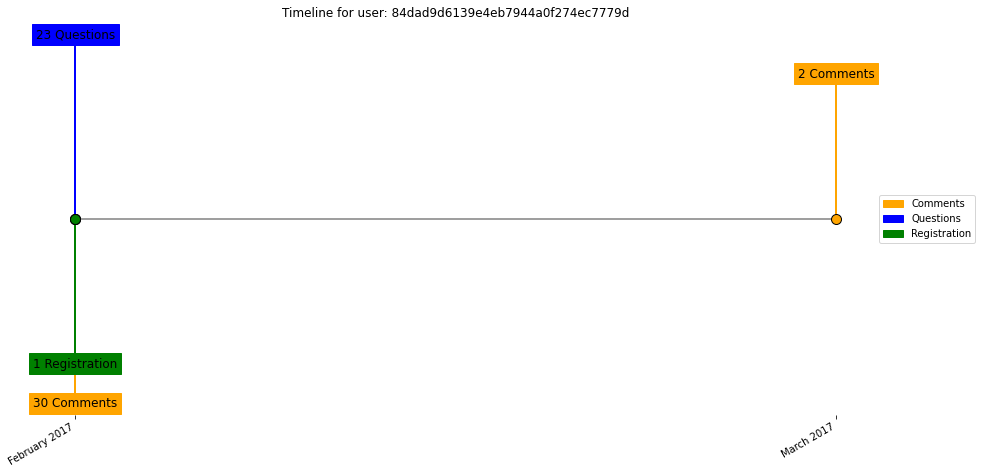

In [ ]:
user_id = stu_sample_of_5_ids[0]
plot_user_activity(user_id=user_id, xticks_type='Month', xticks_interval=1)

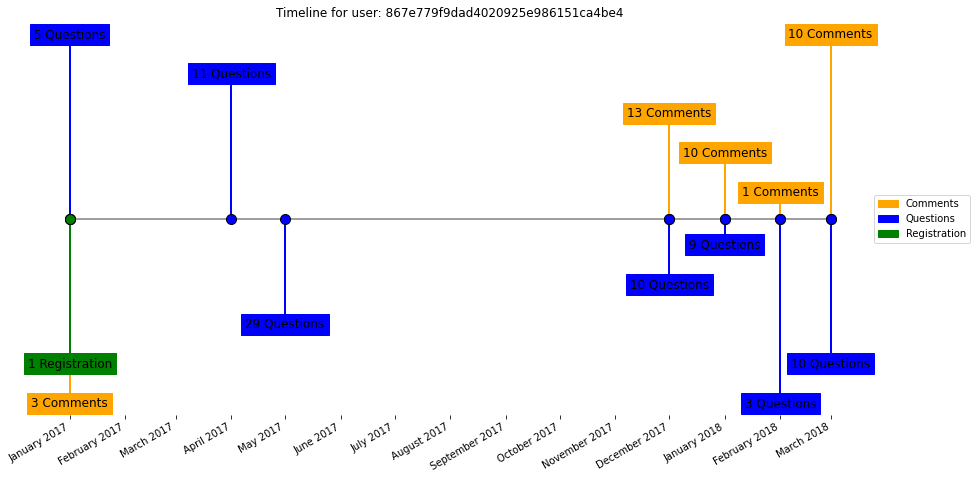

In [ ]:
user_id = stu_sample_of_5_ids[1]
plot_user_activity(user_id=user_id, xticks_type='Month', xticks_interval=1)

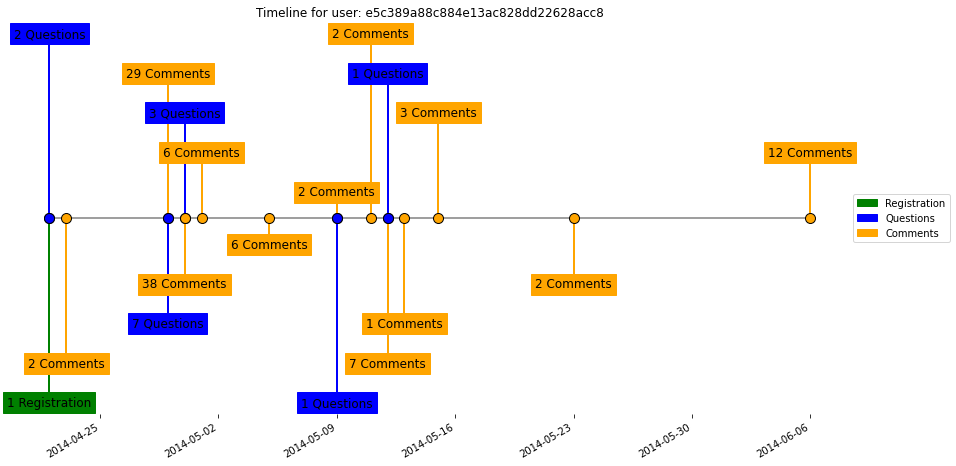

In [ ]:
user_id = 'e5c389a88c884e13ac828dd22628acc8'
plot_user_activity(user_id=user_id, xticks_type='Day', xticks_interval=7)

### Dependency Graph
The Dependency Graph should help to identify some relations between the different entities. For example, it shows graphically if there is a relation between the hashtags of a professional and his answered questions.

In [ ]:
def plot_dependecy_graph(emails_id=[], details=['tag', 'group', 'school'], details_min_edges=1):
    """ Merges all relevant data for a given email together and builds a dependency graph and report.
        
        :param emails_id: 'email_id' of the 'emails' dataframe
        :param details: List which details should be ploted (default: ['tags', 'groups', 'schools'])
        :param details_min_edges: How many edges a node from the details list must have (default: 1 (show all))
    """  
    graph_edges = pd.DataFrame()
    graph_nodes = pd.DataFrame()
    #email
    graph_emails = emails[emails['emails_id'].isin(emails_id)]
    graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_emails['emails_id'], 'type':'email', 'color':'grey', 'size':1})])
    #questions
    graph_matches = matches[matches['matches_email_id'].isin(graph_emails['emails_id'])]
    graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_matches['matches_question_id'], 'type':'question', 'color':'blue', 'size':1})])
    graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_matches['matches_email_id'], 'target':graph_matches['matches_question_id']})])
    #answers
    graph_answers = answers[answers['answers_question_id'].isin(graph_matches['matches_question_id'])]
    graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_answers['answers_id'], 'type':'answer', 'color':'red', 'size':1})])
    graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_answers['answers_question_id'], 'target':graph_answers['answers_id']})])
    #professionals
    graph_professionals = answers[answers['answers_question_id'].isin(graph_matches['matches_question_id'])]
    graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_professionals['answers_author_id'], 'type':'professional', 'color':'cyan', 'size':1})])
    graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_professionals['answers_id'], 'target':graph_professionals['answers_author_id']})])
    #students
    graph_students = questions[questions['questions_id'].isin(graph_matches['matches_question_id'])]
    graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_students['questions_author_id'], 'type':'student', 'color':'green', 'size':1})])
    graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_students['questions_id'], 'target':graph_students['questions_author_id']})])
    if 'tag' in details:
        #question tags
        graph_questions_tags = tag_questions[tag_questions['tag_questions_question_id'].isin(graph_matches['matches_question_id'])]
        graph_questions_tags = pd.merge(graph_questions_tags, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_questions_tags['tags_tag_name'], 'type':'tag', 'color':'yellow', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_questions_tags['tag_questions_question_id'], 'target':graph_questions_tags['tags_tag_name']})])  
        #professional tags
        graph_professionals_tags = tag_users[tag_users['tag_users_user_id'].isin(graph_professionals['answers_author_id'])]
        graph_professionals_tags = pd.merge(graph_professionals_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_professionals_tags['tags_tag_name'], 'type':'tag', 'color':'yellow', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_professionals_tags['tag_users_user_id'], 'target':graph_professionals_tags['tags_tag_name']})])     
        #students tags
        graph_students_tags = tag_users[tag_users['tag_users_user_id'].isin(graph_students['questions_author_id'])]
        graph_students_tags = pd.merge(graph_students_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_students_tags['tags_tag_name'], 'type':'tag', 'color':'yellow', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_students_tags['tag_users_user_id'], 'target':graph_students_tags['tags_tag_name']})]) 
    if 'group' in details:
        #professional group
        graph_professionals_group = group_memberships[group_memberships['group_memberships_user_id'].isin(graph_professionals['answers_author_id'])]
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_professionals_group['group_memberships_group_id'], 'type':'group', 'color':'orange', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_professionals_group['group_memberships_user_id'], 'target':graph_professionals_group['group_memberships_group_id']})]) 
        #students group
        graph_students_group = group_memberships[group_memberships['group_memberships_user_id'].isin(graph_students['questions_author_id'])]
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_students_group['group_memberships_group_id'], 'type':'group', 'color':'orange', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_students_group['group_memberships_user_id'], 'target':graph_students_group['group_memberships_group_id']})]) 
    if 'school' in details:
        #professional school
        graph_professionals_school = school_memberships[school_memberships['school_memberships_user_id'].isin(graph_professionals['answers_author_id'])]
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_professionals_school['school_memberships_school_id'], 'type':'school', 'color':'purple', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_professionals_school['school_memberships_user_id'], 'target':graph_professionals_school['school_memberships_school_id']})])
        #students school
        graph_students_school = school_memberships[school_memberships['school_memberships_user_id'].isin(graph_students['questions_author_id'])]
        graph_nodes = pd.concat([graph_nodes, pd.DataFrame({'node':graph_students_school['school_memberships_school_id'], 'type':'school', 'color':'purple', 'size':1})])
        graph_edges = pd.concat([graph_edges, pd.DataFrame({'source':graph_students_school['school_memberships_user_id'], 'target':graph_students_school['school_memberships_school_id']})])
    
    # check min count of edges for details
    graph_nodes = graph_nodes.drop_duplicates()
    temp = pd.concat([graph_edges[['source', 'target']], graph_edges[['target', 'source']].rename(columns={'target':'source', 'source':'target'})])
    temp = temp[temp['source'].isin(graph_nodes[graph_nodes['type'].isin(details)]['node'])]
    temp = temp.drop_duplicates().groupby('source').size()
    graph_nodes = graph_nodes[~graph_nodes['node'].isin(temp[temp<details_min_edges].index.values)]
    graph_edges = graph_edges[(~graph_edges['source'].isin(temp[temp<details_min_edges].index.values)) & (~graph_edges['target'].isin(temp[temp<details_min_edges].index.values))]
    graph_nodes_color = graph_nodes['color']
    
    plt.figure(figsize=(15, 15)) 
    G = nx.Graph()
    G.add_nodes_from(graph_nodes['node'])
    G.add_edges_from({tuple(row) for i,row in graph_edges[['source', 'target']].iterrows()})
    nx.draw_networkx(G, with_labels=True, node_color=graph_nodes_color, font_size=8, node_size=900/len(emails_id))
    plt.title('Dependency graph for email {}'.format(emails_id))
    plt.axis('off')

    legend = []
    for index, row in graph_nodes[['type', 'color']].drop_duplicates().iterrows():
        legend += [mpatches.Patch(color=row['color'], label=row['type'])]
    plt.legend(handles=legend)
    plt.show()

**Example 1**

In example 1 we have one email with two questions with a few questions tags. There are several answers for the question. The students from the questions haven't any group or school membership. The professionals have more motivation to subscribe some tags and specify there school membership. But only two professionals have joined a group.

In the second plot of this example we increase the parameter details_min_edges to 2. This provides a better overview of which tags are used by multiple nodes. For example, the 'financial-planing' node is used in two questions and is subscribed by the professional and student at the same time.

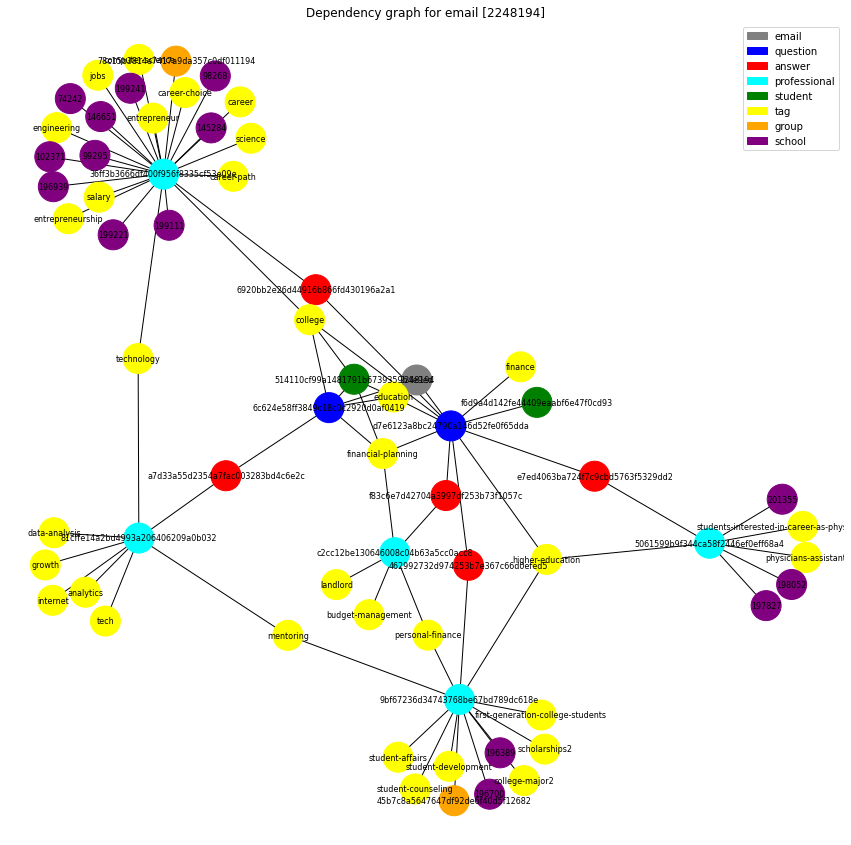

In [ ]:
emails_id = emails.loc[seed, 'emails_id']
plot_dependecy_graph(emails_id=[emails_id])

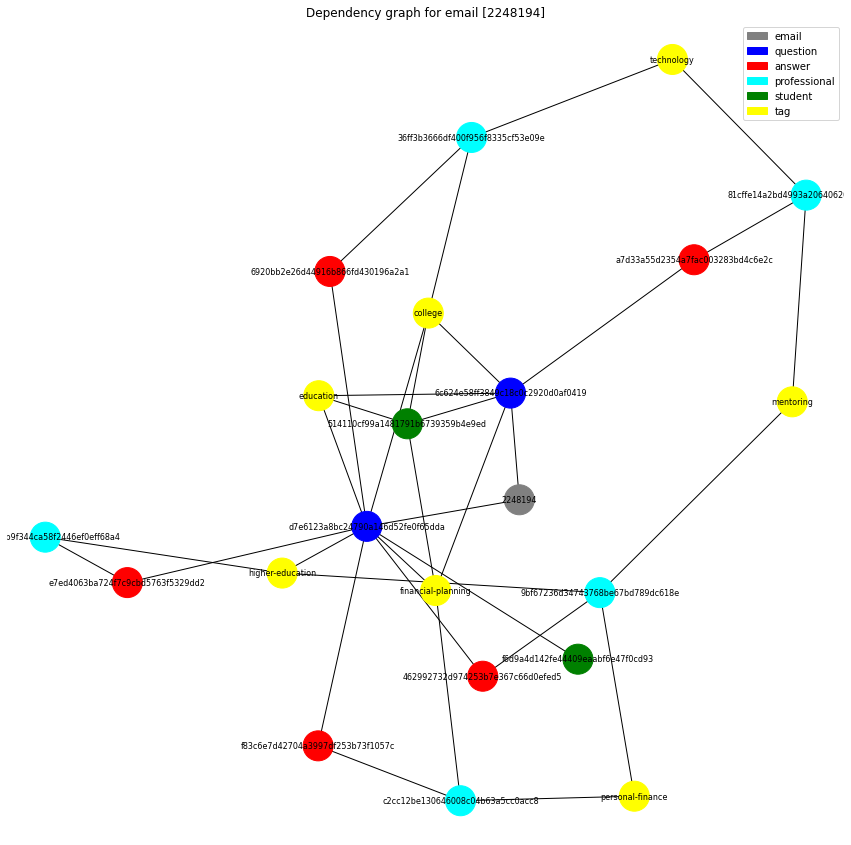

In [ ]:
emails_id = emails.loc[seed, 'emails_id']
plot_dependecy_graph(emails_id=[emails_id], details_min_edges=2)

**Example 2**

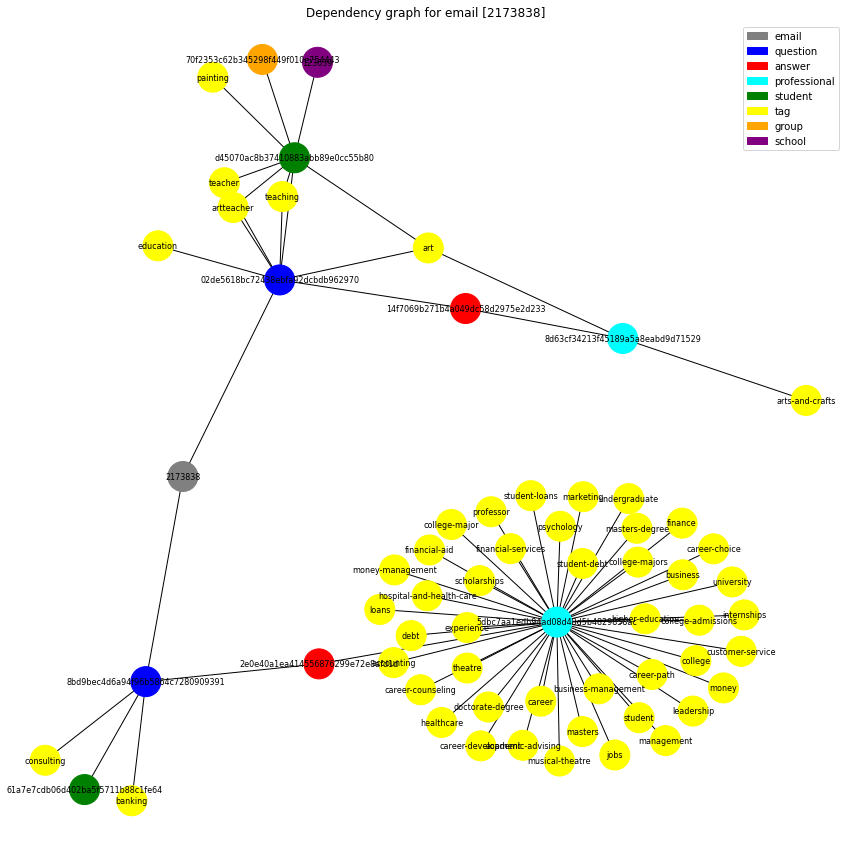

In [ ]:
emails_id = emails.loc[seed*2, 'emails_id']
plot_dependecy_graph(emails_id=[emails_id])

## Topic Model (LDA)
In this section we will implement a LDA (Latent Dirichlet Allocation) Model to get topic probabilities for the questions. We can use this to see how topics are distributed across questions and which words characterize them.  
New questions can be allocated to topics and forwarded to professional who are familiar with these topics.

1. Use NLP on the Questions corpus.  
    a. Use part-of-speech tagging to filter words.  
    b. Filter extrem values from corpus.  
    c. Calculate the tf-idf. 
2. Train a LDA Model.  
3. Give the topics a headline
4. Get the topic probability of a new question text.

### Parameters
The LDA model is created with Gensim library. There are many parameters that can be set and have an effect on the trained model. It is an unsupervised model and is not easy to choose the right parameters. We tested around with different parameters and checked whether it comes close to our expectations.

The Gensim Dictionary Filter parameters are for a preprocessing, to filter out tokens in the dictionary by their frequency.

The LDA parameters are for training the model. Most interesting is the num_topics which specifies how many topics we want to have. And alpha is the parameter of the Dirichlet prior on the per-document topic distributions.

In [ ]:
# Gensim Dictionary Filter
extremes_no_below = 20
extremes_no_above = 0.6
extremes_keep_n = 8000

# LDA
num_topics = 21
passes = 15
chunksize = 1000
alpha = 1/50

### Functions

In [ ]:
def get_model_results(ldamodel, corpus, dictionary):
    """ Create doc-topic probabilities table and visualization for the LDA model

    """  
    vis = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df  

In [ ]:
def get_model_wordcloud(ldamodel):
    """ Create a Word Cloud for each topic of the LDA model

    """  
    plot_cols = 3
    plot_rows = math.ceil(num_topics / 3)
    axisNum = 0
    plt.figure(figsize=(5*plot_cols, 3*plot_rows))
    for topicID in range(ldamodel.state.get_lambda().shape[0]):
        #gather most relevant terms for the given topic
        topics_terms = ldamodel.state.get_lambda()
        tmpDict = {}
        for i in range(1, len(topics_terms[0])):
            tmpDict[ldamodel.id2word[i]]=topics_terms[topicID,i]

        # draw the wordcloud
        wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
        axisNum += 1
        ax = plt.subplot(plot_rows, plot_cols, axisNum)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = topicID
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0, y=0)
    plt.show()

In [ ]:
def topic_query(data, query):
    """ Get Documents matching the query with the doc-topic probabilities

    """  
    result = data
    result['sort'] = 0
    for topic in query:
        result = result[result[topic] >= query[topic]]
        result['sort'] += result[topic]
    result = result.sort_values(['sort'], ascending=False)
    result = result.drop('sort', axis=1)
    result = result.head(5)
    return result

In [ ]:
def get_text_topics(text, top=20):
    """ Get the topics probabilities for a text and highlight relevant words

    """    
    def token_topic(token):
        return topic_words.get(token, -1)
    
    colors = ['\033[46m', '\033[45m', '\033[44m', '\033[43m', '\033[42m', '\033[41m', '\033[47m']    
    nlp_tokens = nlp_preprocessing([text])

    bow_text = [lda_dic.doc2bow(doc) for doc in nlp_tokens]
    bow_text = lda_tfidf[bow_text]
    topic_text = lda_model.get_document_topics(bow_text)
    topic_text = pd.DataFrame.from_records([{v:k for v, k in row} for row in topic_text])
    
    print('Question:')
    topic_words = []
    topic_labeled = 0
    for topic in topic_text.columns.values:
        topic_terms = lda_model.get_topic_terms(topic, top)
        topic_words = topic_words+[[topic_labeled, lda_dic[pair[0]], pair[1]] for pair in topic_terms]
        topic_labeled += 1
    topic_words = pd.DataFrame(topic_words, columns=['topic', 'word', 'value']).pivot(index='word', columns='topic', values='value').idxmax(axis=1)
    nlp_doc = nlp(text)
    text_highlight = ''.join([x.string if token_topic(x.lemma_.lower()) <0  else colors[token_topic(x.lemma_.lower()) % len(colors)] + x.string + '\033[0m' for x in nlp_doc])
    print(text_highlight) 
    
    print('\nTopics:')
    topic_labeled = 0
    for topic in topic_text:
        print(colors[topic_labeled % len(colors)]+'Topic '+str(topic)+':', '{0:.2%}'.format(topic_text[topic].values[0])+'\033[0m')
        topic_labeled += 1

    # Plot Pie chart
    plt_data = topic_text
    plt_data.columns = ['Topic '+str(c) for c in plt_data.columns]
    plt_data['Others'] = 1-plt_data.sum(axis=1)
    plt_data = plt_data.T
    plt_data.plot(kind='pie', y=0, autopct='%.2f')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Topics Probabilities')
    plt.show()

### Create Model 
Now we will train the LDA model. For this we take again the preprocessd *nlp_tokens* as basis. We filter out extreme values depending on the defined parameters and calculate the tf-idf corpus. Then we train the LDA model and calculate the Document-Topic Probabilities for our questions.  
With the current parameters it takes 2 minutes and 30 seconds to train the model. But for a productive use, it's not necessary to train the LDA model frequently. To achieve the model persistency, the [save()](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.save) and [load()](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.load) methods can be used.

In [ ]:
lda_tokens = questions['nlp_tokens']
# Gensim Dictionary
lda_dic = gensim.corpora.Dictionary(lda_tokens)
lda_dic.filter_extremes(no_below=extremes_no_below, no_above=extremes_no_above, keep_n=extremes_keep_n)
lda_corpus = [lda_dic.doc2bow(doc) for doc in lda_tokens]

lda_tfidf = gensim.models.TfidfModel(lda_corpus)
lda_corpus = lda_tfidf[lda_corpus]

# Create LDA Model
lda_model = gensim.models.ldamodel.LdaModel(lda_corpus, num_topics=num_topics, 
                                            id2word = lda_dic, passes=passes,
                                            chunksize=chunksize,update_every=0,
                                            alpha=alpha, random_state=seed)

In [ ]:
# Create Visualization and Doc-Topic Probabilities
lda_vis, lda_result = get_model_results(lda_model, lda_corpus, lda_dic)
lda_questions = questions[['questions_id', 'questions_title', 'questions_body']]
lda_questions = pd.concat([lda_questions, lda_result.add_prefix('Topic_')], axis=1)

### Topics
Each wordcloud shows a topic and the top words who define the topic. 
Here some examples:    
**Topic 3** is for **payment** (*loan, finance, money, pay, debt, ...*)  
**Topic 4** is for **veterinary** (*veterinary, animal, vet, medicine, ...*)  
**Topic 7** is for **architecture** (*architect, construction, ...*) and **marketing** (*marketing, advertising, communication, ...*)  
**Topic 14** is for **sport** (*sport, soccer, athletic, basketball, ...*)  
**Topic 16** is for **engieers** (*eingineering, mechanical, aerospace, electrical, ...*)  
**Topic 17** is for **computer** science (*computer, software, programming, ...*)  
**Topic 18** is for **health** (*medicine, doctor, nurse, medical, ...*) 

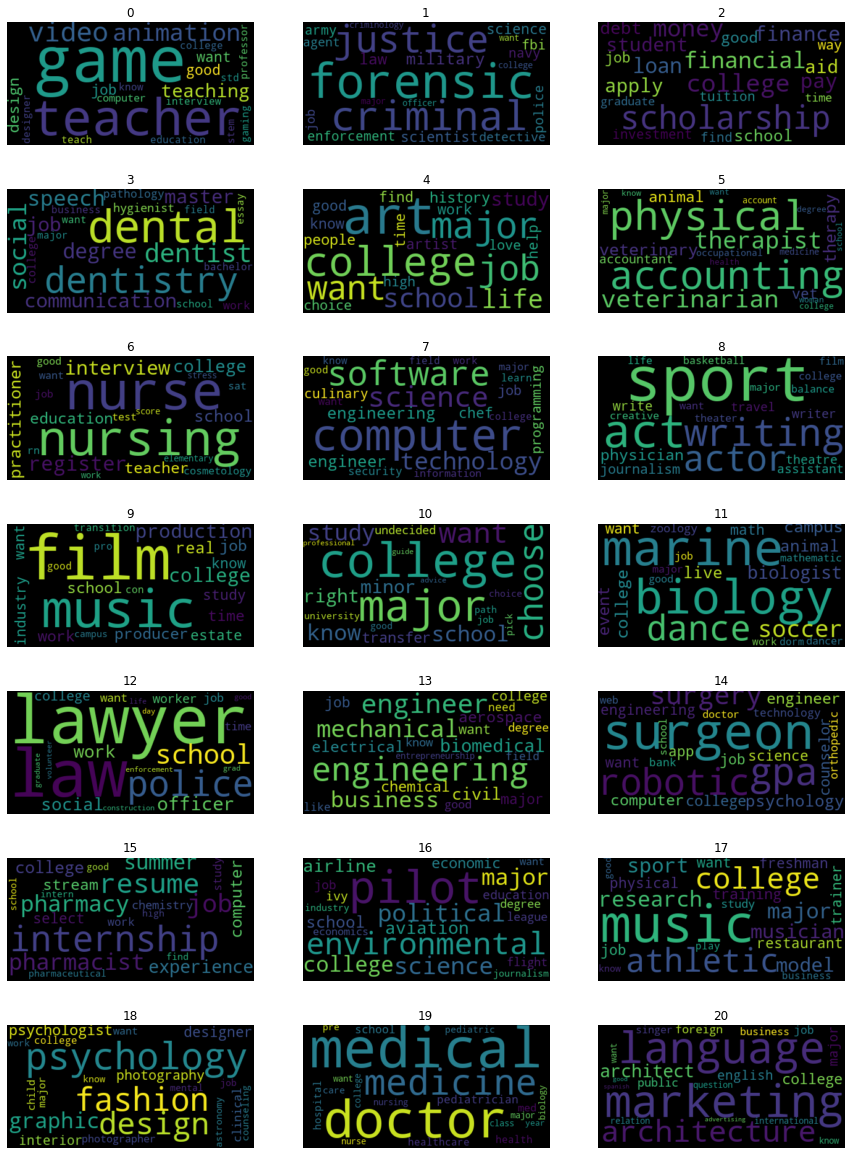

In [ ]:
get_model_wordcloud(lda_model)

In [ ]:
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.080698  0.010920       1        1  3.869343
1     -0.021437 -0.024566       2        1  3.703164
2      0.066456  0.050016       3        1  9.215193
3     -0.002130 -0.006821       4        1  3.012540
4      0.021353  0.023226       5        1  6.744941
5      0.040685 -0.071422       6        1  4.096361
6      0.087873 -0.042529       7        1  4.925624
7     -0.120124 -0.018135       8        1  6.283787
8      0.025423  0.087688       9        1  4.596561
9      0.028698  0.078057      10        1  2.958657
10     0.050047 -0.009839      11        1  5.604872
11     0.016779  0.035433      12        1  3.045198
12     0.030179 -0.001357      13        1  4.233559
13    -0.072493 -0.050063      14        1  6.498305
14    -0.045386 -0.058211      15        1  2.623753
15    -0.042692 -0.016983      16        1  4.688657
16    -0.018265 -0.007951      17        1  3.541069
17     0.017178  0.047284      18        1  2.754000
18    -0.032877  0.011138      19        1  4.300713
19     0.086256 -0.102268      20        1  7.808355
20    -0.034826  0.066383      21        1  5.495348, topic_info=            Term        Freq       Total Category  logprob  loglift
114  engineering  534.000000  534.000000  Default  30.0000  30.0000
511        nurse  315.000000  315.000000  Default  29.0000  29.0000
288     computer  413.000000  413.000000  Default  28.0000  28.0000
50   scholarship  318.000000  318.000000  Default  27.0000  27.0000
64         music  196.000000  196.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
136       school   22.380606  632.197709  Topic21  -5.2327  -0.4397
91         learn   19.119923  197.449403  Topic21  -5.3902   0.5665
240         look   19.826587  278.287923  Topic21  -5.3539   0.2596
52       student   19.528235  366.331483  Topic21  -5.3691  -0.0304
198         high   19.243087  382.064992  Topic21  -5.3838  -0.0872

[1193 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
918       5  0.151471  acceptable
918      16  0.151471  acceptable
918      19  0.454414  acceptable
476       1  0.048289     account
476       2  0.016096     account
...     ...       ...         ...
1583     12  0.844389   zoologist
561       2  0.120530     zoology
561       4  0.040177     zoology
561       6  0.040177     zoology
561      12  0.723182     zoology

[6730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

### Document-Topic Probabilities 
Here are the topic probabilites for the first five questions.
Topics with NaN values for these five question were deleted.
If a topic probabilites is under a give threshold it gets automaticaly a NaN value

In [ ]:
lda_questions.head(5).dropna(axis=1, how='all').T

,0,1,2,3,4
questions_id,332a511f1569444485cf7a7a556a5e54,eb80205482e4424cad8f16bc25aa2d9c,4ec31632938a40b98909416bdd0decff,2f6a9a99d9b24e5baa50d40d0ba50a75,5af8880460c141dbb02971a1a8369529
questions_title,Teacher career question,I want to become an army officer. What can I d...,Will going abroad for your first job increase ...,To become a specialist in business management...,Are there any scholarships out there for stude...
questions_body,What is a maths teacher? what is a ma...,I am Priyanka from Bangalore . Now am in 10th ...,I'm planning on going abroad for my first job....,i hear business management is a hard way to ge...,I'm trying to find scholarships for first year...
Topic_0,0.859044,NaN,NaN,NaN,NaN
Topic_1,NaN,0.842313,NaN,NaN,NaN
Topic_2,NaN,NaN,0.917881,NaN,0.871524
Topic_13,NaN,NaN,NaN,0.888103,NaN


**Example 1**

The example with the data science text was assigned to topic 17 with 85%. 

The highlighted text are words, who define the topic.  

A look at the previously created wordcloud shows that we define topic 17 for *computer science*.

Question:
I will finish my college next year and would like to start a career as a Data Scientist. 

What is the best way to become a good Data Scientist? #data-science

Topics:
Topic 7: 84.90%


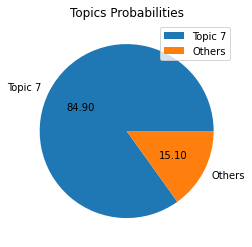

In [ ]:
query_text = 'I will finish my college next year and would like to start a career as a Data Scientist. \n\n'\
            +'What is the best way to become a good Data Scientist? #data-science'
get_text_topics(query_text, 100)

**Example 2**

Now I would like to make a query, which gives me back documents with the topic finance (Topic 3) and health (Topic 18). The first two questions are about the cost (Topic 3) to become a doctor (Topic 18).

In [ ]:
query = {'Topic_3':0.4, 'Topic_18':0.4}
topic_query(lda_questions, query).dropna(axis=1, how='all').head(2).T

,23794,19907
questions_id,9f8a56f991d5429487bc51a55c39dece,76b1b0a8345d43388e2804c81bebe03a
questions_title,Is being a Graphic Designer at a studio/compan...,How hard is it to double major in college?
questions_body,I am soon going to graduate if I can get my ac...,I am not sure which field I would like to go i...
Topic_18,0.461242,0.402651
Topic_3,0.46073,0.507593


Question:
Is spending 8 years learning really worth becoming a doctor?

Right now, I'm a sophomore in high school and very often people ask me who I want to be after college. My response had usually been a doctor, but after doing some research about the job, I understand that becoming an actual doctor is a very rocky step. I feel like a lot of time is needed, as well as a lot of financial resources to finish college and then medical school. As well, I understand that after med school I will need to spend another 2-4 years as an intern and then possibly more to specialize in something. So, I'm just wondering whether in the end it will be worth it, because if I do choose this path I feel like the next 12, or so years of my life I will be a student and possibly not earning enough to adequately support myself and pay the school debts. #doctor #medical-school #student-loans #learning #debt #expenses

Topics:
Topic 2: 59.54%
Topic 19: 34.34%


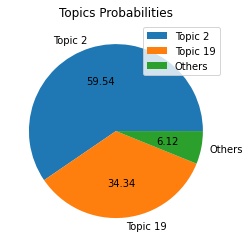


Question:
Are there ways to pay off your student debt through medical school?

I know it can get expensive and medical school can cost a lot of money, but is it true that you can go to rural places or even other countries to pay of your student debt? #medical #hospital-and-health-care #medicine #doctor #college #career #career-counseling 

Topics:
Topic 2: 54.68%
Topic 19: 37.17%


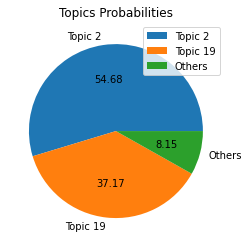

In [ ]:
get_text_topics(questions['questions_full_text'][7582], 50)
print()
get_text_topics(questions['questions_full_text'][1597], 50)

## Recommendation Engine
The recommendation engine should help to answer the following questions:
- When a student asks a question, are there already any similar questions that might help him?
- When a student asks a question, there may already be similar questions. This could help him with his own question.
- Which professionals are most expected to answer the new question?
New questions should be answered quickly. For this reason it should be forwarded to professionals who can answer the questions best.
- Which questions should be forwarded to a professional to answer?
The previous point was from the perspective of a new question. Here the professional is the focus. Every professional should be displayed questions, which could be possible for him to answer (e.g. home screen or daily/weekly e-mail).
- Which hashtags might interest a user because of his previous activities? The last point is to recommend hashtags to a user that might be of interest to him.

### Get similar Questions 
It is important for the Recommendation to identify similar questions. For this purpose, three methods have been implemented:

**Text similarity:** First use NLP on the complete Question corpus and the new question text (Use part-of-speech tagging to filter words and calculate the tf-idf for a better information retrieval). After this we calculate the cosine similarity between the new question and the corpus. This makes it possible for us to identify similar questions that have already been asked. 

**Tags similarity:** Use the Jaccard similarity based on the hashtags of the questions to identify similar questions.  

**Topic similarity:** Use the cosine similarity of the topic probabilities between the new question and the actual question corpus.

In [ ]:
def get_similar_text_questions(questions_text, questions=questions, threshold=0.01, top=5, answered=True):
    """ Calculates the similarity to the existing questions and returns the most similar ones.
        
        :param questions_text: List with text of new questions to get the similiarities
        :param threshold: Threshold to filter out all questions with similarity below the value (default: 0.01)
        :param top: Top N similar questions (default: 5)
        :param answered: Consider only answered questions (default: True)
        :return result: DataFrame with the top similar questions
    """ 
    nlp_corpus = [' '.join(x) for x in questions['nlp_tokens']]
    nlp_text = [' '.join(x) for x in nlp_preprocessing(questions_text)]
    vectorizer = TfidfVectorizer()
    vectorizer.fit(nlp_corpus)
    corpus_tfidf = vectorizer.transform(nlp_corpus)
    
    text_tfidf = vectorizer.transform(nlp_text)
    sim = cosine_similarity(corpus_tfidf, text_tfidf)
    result = pd.DataFrame({'questions_id':np.tile(questions['questions_id'], sim.shape[1]),
                           'similarity':sim.reshape(-1,),
                          'title':np.tile(questions['questions_title'], sim.shape[1]),
                          'body':np.tile(questions['questions_body'], sim.shape[1]),
                           'questions_tags':np.tile(questions['questions_tags'], sim.shape[1]),
                          'questions_answers_count':np.tile(questions['questions_answers_count'], sim.shape[1]),
                          'questions_hearts':np.tile(questions['questions_hearts'], sim.shape[1]),},
                         index=np.tile(questions.index, sim.shape[1]))
    if answered:
        result = result[result['questions_answers_count'] > 0]
    result = result[result['similarity'] >= threshold].sort_values('similarity', ascending=False).head(top)
    return result

def get_similar_tags_questions(tags, questions=questions, threshold=0.01, top=5, answered=True):
    """ Calculates the similarity to the existing questions and returns the most similar ones.
        
        :param tags: List with tags to get the similiarities
        :param threshold: Threshold to filter out all questions with similarity below the value (default: 0.01)
        :param top: Top N similar questions (default: 5)
        :param answered: Consider only answered questions (default: True)
        :return result: DataFrame with the top similar questions
    """ 
    sim = questions['questions_tags'].fillna('').apply(lambda x: len(set(x) & set(tags))/len(set(x) | set(tags)) if len(set(x) | set(tags)) > 0 else 0)
    result = pd.DataFrame({'questions_id':questions['questions_id'],
                           'similarity':sim,
                          'title':questions['questions_title'],
                          'body':questions['questions_body'],
                           'questions_tags':questions['questions_tags'],
                          'questions_answers_count':questions['questions_answers_count'],
                          'questions_hearts':questions['questions_hearts'],},
                         index=questions.index)
    if answered:
        result = result[result['questions_answers_count'] > 0]
    result = result[result['similarity'] >= threshold].sort_values('similarity', ascending=False).head(top)
    return result

def get_similar_topic_questions(questions_text, questions=questions, threshold=0.01, top=5, answered=True):
    """ Calculates the topic similarity to the existing questions and returns the most similar ones.
        
        :param questions_text: List with text of new questions to get the similiarities
        :param threshold: Threshold to filter out all questions with similarity below the value (default: 0.01)
        :param top: Top N similar questions (default: 5)
        :param answered: Consider only answered questions (default: True)
        :return result: DataFrame with the top similar questions
    """ 
    nlp_corpus = questions['nlp_tokens']
    bow_corpus = [lda_dic.doc2bow(doc) for doc in nlp_corpus]
    bow_corpus = lda_tfidf[bow_corpus]
    topic_corpus = lda_model.get_document_topics(bow_corpus, minimum_probability=0)
    topic_corpus = pd.DataFrame.from_records([{v:k for v, k in row} for row in topic_corpus])
    
    nlp_text = nlp_preprocessing(questions_text)
    bow_text = [lda_dic.doc2bow(doc) for doc in nlp_text]
    bow_text = lda_tfidf[bow_text]
    topic_text = lda_model.get_document_topics(bow_text, minimum_probability=0)
    topic_text = pd.DataFrame.from_records([{v:k for v, k in row} for row in topic_text])
    
    sim = cosine_similarity(topic_corpus.fillna(0), topic_text.fillna(0))
    result = pd.DataFrame({'questions_id':np.tile(questions['questions_id'], sim.shape[1]),
                           'similarity':sim.reshape(-1,),
                          'title':np.tile(questions['questions_title'], sim.shape[1]),
                          'body':np.tile(questions['questions_body'], sim.shape[1]),
                           'questions_tags':np.tile(questions['questions_tags'], sim.shape[1]),
                          'questions_answers_count':np.tile(questions['questions_answers_count'], sim.shape[1]),
                          'questions_hearts':np.tile(questions['questions_hearts'], sim.shape[1]),},
                         index=np.tile(questions.index, sim.shape[1]))
    if answered:
        result = result[result['questions_answers_count'] > 0]
    result = result[result['similarity'] >= threshold].sort_values('similarity', ascending=False).head(top)
    return result

In [ ]:
query_text = ['I will finish my college next year and would like to start a career as a Data Scientist. \n\n'\
            +'What is the best way to become a good Data Scientist? #data-science']
questions_corpus = questions[questions['questions_date_added'] > '2017-01-01']
get_similar_text_questions(query_text, questions=questions_corpus).T

,11278,2411,20084,20062,121
questions_id,bbe68647fcc84d04aad988a2891fbd9a,8cc3c5d8df3d405d87aa59d042330200,4e6b1b323c3e476ba03c33f75df9304a,97d6255739d547afba83107bbc3a5ac4,beb736d5b2dc49048f7c1b46d5a6b0ea
similarity,0.760404,0.622366,0.525967,0.513088,0.424484
title,what should I learn to be a data scientist?,How to become a data scientist?,What are the best data science courses/nanodeg...,What are some skills needed to get into Data S...,What is the difference between data science an...
body,"I want to be a data scientist, what online co...","Hello,\r\n\r\nI am going to a liberal art coll...",I'm currently a third year computer science ma...,There is not substantial information out there...,"I've been looking into data science careers, a..."
questions_tags,[datascience],"[technology, college-advice, computer-science,...","[computer-science, computer-software, data-ana...","[programming, finance, data-analysis, data-min...","[computer-science, computer-software, data-ana..."
questions_answers_count,2,3,5,5,4
questions_hearts,2,2,6,5,4


### Recommend new Question to Professionals <a id="recommender_new_questions"></a>  
New questions should be answered by professionals as soon as possible. If a question is forwarded to an professional, he should be able to answer it. If questions that are not relevant are recommended more often, this will reduce the motivation of the professional to continue using the service.  
The first step is to check which similar questions already exist for the new question and who answered them. In order to make a recommendation, certain scores are calculated, which flow into a final calculation to make the best recommendation.  
The individual scores can be weighted differently (e.g. the activity level is more important than the hearts), to calculate the final score. It would be best if we had an professional, who has already answered many similar questions quickly and is still active.

$final\_score = \sum_{p \in P}(p_{weight}*p_{value}) * \sum_{q \in Q}(q_{weight}*q_{value})$  
$Q = $ All defined question scores (similarity, answer time, ...)  
$q_{weight} = $ The weight for question score $q$  
$q_{value} = $ The calculated base score for question score $q$  
$P = $ All defined professional scores (last activity, professional hearts, ...)  
$p_{weight} = $ The weight for professional score $p$  
$p_{value} = $ The calculated base score for professional score $p$  

We prefer high scores, so it is necessary for some to adjust them. e.g. professionals should be preferred which have answered fast in the past. The multiplicative inverse is then used for these ($s_{value} \to \frac{1}{s_{value}})$. We also using the logarithm (actual base 10) to normalize the scores. On some score it's helpfull to add the base self bevor calculate the logarithm. For some scores it's helpful to add the base itself before calculate the logarithm. 

The following scores actual exists for questions:  
* **similarity**: How similar are the questions to the new question?  
`score_similarty` = cosine similarity between question and new question  
* **answer time**: How long did it take to answer that question?  
`score_answer_time` $=\frac{1}{log_{10}(10+value)}$ with $value=$ The days that have passed since the similar question was answered.
* **answer rank**: How many answers have there been to this question before?  
`score_answer_rank` $=\frac{1}{log_{10}(9+value)}$ with $value=$ The amount of previous answers to the question.
* **answers hearts**: How many '*hearts*' were there for the answer?  
`score_answer_hearts` $=log_{10}(10+value)$ with $value=$ The amount of hearts for the answer from the professional.  

And the following scores actual exists for professionals:  
* **activitiy**: When was the last activity of the user?  
`score_activity` $=\frac{1}{log_{10}(10+value)}$ with $value=$ The days that have passed since the last activity of the professional.  
* **professional hearts**: How many '*hearts*' has the author already collected?  
`score_professional_hearts` $=log_{10}(10+value)$ with $value=$ The total amount of hearts of the professional.  

In [ ]:
def recommend_new_question(question_text, questions=questions, top_questions=10, top_professionals=5, weights=[1, 1, 1, 1, 1, 1]):
    """ Determines which professionals are best qualified to answer the question.
        
        :param questions_text: List with text of new questions to get the similiarities
        :param top_questions: Top N similar questions (default: 10)
        :param top_professionals: Top N recommended professionals (default: 5)
        :param weights: Weights for the various scores (default: uniform distribution)
        :return recommendation: DataFrame with the top scored professionals
        :return result: DataFrame with all rows and columns to be able to understand the calculation.
    """ 
    relevant_columns = ['questions_id', 'similarity', 'questions_answers_count', 
                        'answers_author_id', 'time_delta_answer', 'answers_time_rank', 'answers_hearts', 
                        'time_delta_last_activity', 'professional_answers_hearts', 'questions_tags', 'professionals_tags']
    sim_questions = get_similar_text_questions(question_text, questions=questions, threshold=0.0, top=top_questions, answered=True)
    result = pd.merge(sim_questions, answers, left_on='questions_id', right_on='answers_question_id', how='left')
    result = pd.merge(result, professionals, left_on='answers_author_id', right_on='professionals_id', how='left')
    
    result['time_delta_answer'] = result['time_delta_answer'].dt.days
    result['time_delta_last_activity'] = (actual_date - result['date_last_activity']).dt.days
    result = result[relevant_columns]
    result['score_activity'] = 1/np.log10(10+result['time_delta_last_activity'])
    result['score_answer_time'] = 1/np.log10(10+result['time_delta_answer'])
    result['score_answer_rank'] = 1/np.log10(9+result['answers_time_rank'])
    result['score_answers_hearts'] = np.log10(10+result['answers_hearts'])
    result['score_professional_hearts'] = np.log10(10+result['professional_answers_hearts'])
    result['final_score'] = (weights[0]*result['similarity']+
                             weights[1]*result['score_answer_time']+
                             weights[2]*result['score_answer_rank']+
                             weights[3]*result['score_answers_hearts']
                            )*(
                             weights[4]*result['score_activity']+
                             weights[5]*result['score_professional_hearts'])
    
    recommendation = result.groupby('answers_author_id')['final_score'].sum().sort_values(ascending=False).head(top_professionals)
    return recommendation, result

In [ ]:
weights=[3, 1, 1, 0.3, 1, 0]
query_text = ['I will finish my college next year and would like to start a career as a Data Scientist. \n\n'\
            +'What is the best way to become a good Data Scientist? #data-science']
questions_corpus = questions[questions['questions_date_added'] > '2017-01-01']
recommendation, scores = recommend_new_question(query_text, questions=questions_corpus, top_questions=10, top_professionals=10, weights=weights)
pd.DataFrame(recommendation)

,final_score
answers_author_id,
d7f9afe721af42b1a03a993909e0568c,5.311369
b75ea3ba7b6440e7a5cf97537a4a73ee,2.445154
cf19b70d554a419eb5addad410f66891,2.423754
887c5a142b42466fb74740d72989fc74,2.249271
0a169aa8c6f54854afaa6783976e52fe,1.822899
cc49ef2285724342a4a6a9595e66243d,1.698382
066f10994b704178950d1645f8855247,1.679340
10b10228914d458789ab5ab9637842c9,1.657876
298a2b574b154a578eb9fef4842b1c23,1.654809


### Recommend Questions for a Professional
There are many questions and it is therefore currently difficult for an professional to find questions which he could answer. To recommend relevant questions to him, we look which questions he has already answered and which hashtags he has subscribed to. Scores are calculated on the basis of these to provide a better recommendation.  
The individual scores can be weighted differently (e.g. the similarity is more important than the number of answers), to calculate the final score. 

$final\_score = \sum_{s \in S}(s_{weight}*s_{value})$  
$S = $ All defined Scores (similarity, question date, ...)  
$s_{weight} = $ The weight for score $s$  
$s_{value} = $ The calculated base score for score $s$  

We prefer high scores, so it is necessary for some to adjust them. e.g. questions should be preferred which do not have many answers yet. The multiplicative inverse is then used for these ($s_{value} \to \frac{1}{s_{value}})$. We also using the logarithm (actual base 10) to normalize the scores. On some score it's helpfull to add the base self bevor calculate the logarithm. For some scores it's helpful to add the base itself before calculate the logarithm.  
The following scores exists:
* **similarity**: How similar are the questions to the already answered questions or hashtags?  
`score_similarty` = cosine similarity between question and new question  
* **question date**: How old is the question?  
`score_date_added` $=log_{10}(value)$ with $value=$ The days that have passed since the question was asked.  
* **answers**: How many answers have the question already?  
`score_answers` $=\frac{1}{log_{10}(10+value)}$ with $value=$ The amount of answers for the question.
* **tags**: Jaccard similiarty between the question hashtags and the professional subscribed hashtags?  
`score_tags` $=\frac{T_q \cap T_p}{T_q \cup T_p} $ with $T_q=$ Question Tags and $T_p=$ Professional Tags.

In [ ]:
def recommend_questions_for_professional(professional_id, questions=questions, top=5, weights=[1, 1, 1, 1]):
    """ Recommends questions for an professional to answer.
        
        :param professional_id: ID of the professional
        :param top: Top N recommended questions (default: 5)
        :param top_professionals: Top N recommended professionals (default: 5)
        :param weights: Weights for the various scores (default: uniform distribution)
        :return recommendation: DataFrame with the top scored professionals
        :return sim_questions: DataFrame with all rows and columns to be able to understand the calculation.
    """ 
    professional = professionals[professionals['professionals_id'] == professional_id]
    professional_tags = professional['professionals_tags'].values[0]
    answered_questions = pd.merge(professional, answers, left_on='professionals_id', right_on='answers_author_id', how='left')
    answered_questions = pd.merge(answered_questions, questions, left_on='answers_question_id', right_on='questions_id', how='left')
    sim_tags_questions = get_similar_tags_questions(professional_tags, questions=questions, top=top**2, answered=False)[['questions_id', 'similarity']]
    sim_questions = get_similar_text_questions(answered_questions['questions_full_text'].fillna('').tolist(), questions=questions, top=top**2, answered=False)[['questions_id', 'similarity']]
    sim_questions = pd.concat([sim_questions, sim_tags_questions])
    sim_questions = sim_questions[~sim_questions['questions_id'].isin(answered_questions['questions_id'])]
    sim_questions = pd.merge(sim_questions, questions, left_on='questions_id', right_on='questions_id')
    sim_questions['time_delta_added'] = (actual_date - sim_questions['questions_date_added']).dt.days
    sim_questions['score_answers'] = 1/np.log10(10+sim_questions['questions_answers_count'])
    sim_questions['score_date_added'] = np.log10(sim_questions['time_delta_added'])
    sim_questions['score_tags'] = sim_questions['questions_tags'].fillna('').apply(lambda x: len(set(x) & set(professional_tags))/len(set(x) | set(professional_tags)) if len(set(x) | set(professional_tags)) > 0 else 0)
    sim_questions['final_score'] = (weights[0]*sim_questions['similarity']+
                                    weights[1]*sim_questions['score_answers']+
                                    weights[2]*sim_questions['score_date_added']+
                                    weights[3]*sim_questions['score_tags'])
    
    recommendation = sim_questions.groupby('questions_id')['final_score'].sum().sort_values(ascending=False).head(top)
    return recommendation, sim_questions

Professional with already 60 answered questions.

In [ ]:
weights=[3, 1, 1, 3]
professional_id = 'd7f9afe721af42b1a03a993909e0568c'
questions_corpus = questions[questions['questions_date_added'] > '2018-01-01']
recommendation, score = recommend_questions_for_professional(professional_id, questions=questions_corpus, weights=weights)
pd.DataFrame(recommendation)

,final_score
questions_id,
b1ac7ac8bbbb4ab2952f070ab1633547,6.595496
3410bf1f3ebc495a9e5c1f2619384770,6.571709
aae03d7233b34d5e899c8974d886abeb,6.537744
d067a2c24d0e4d7fa16a0282a0de0022,6.535440
746b29cda34649c590eb82d8724783b4,6.506412


A new Professional without any answered questions. The recommendation is based on the hashtags.

In [ ]:
weights=[0, 5, 1/5, 3]
professional_id = 'ea75c5fce38348e0a151c3c346929e6a'
questions_corpus = questions[questions['questions_date_added'] > '2018-01-01']
recommendation, score = recommend_questions_for_professional(professional_id, questions=questions_corpus, weights=weights)
pd.DataFrame(recommendation)

,final_score
questions_id,
788c0b73d3e7492f83c8b72012c52a21,6.046687
a1b812a67cd64c87b2fbba9d6623a477,5.940849
1b70ac2e12f3495aa31941153c779dcb,5.940849
cd3b32785e864aa485a157032b9bdea4,5.816991
db2731f5f83c4b8689e2d479b4c39bfd,5.797264


### Recommend new Tags for Users
The current system makes recommendation based on Tags. There are currently over 16000 different tags available. It might be interesting to recommend new tags to users based on their activities.  
We can do this with the following three methods:
* **Recommendation based on the user's answered questions:** If a user has already answered several questions, we can check which tags occurred most frequently in this questions.  
* **Recommendation by other users with similar tags:** If a user has already subscribed to some tags, we can check which other users have subscribed to the same tags. The most common tags that occur with these users can then be used as recommendations.
* **Recommendation based on the user's industry:** If the user has specified an industry, we can determine which other users with the same industry exist. This is used to see which tags are most popular in the industry. With this method a part of the cold start problem can be avoided for newly registered professionals.  


In [ ]:
def get_user_tags(user_id):
    """ Get a list with user tags
        
        :param user_id: ID of the user
        :return user_tags: Series with tags.
    """ 
    user_tags = tag_users[tag_users['tag_users_user_id'] == user_id]
    user_tags = pd.merge(user_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')['tags_tag_name']
    return user_tags

def recommend_tags_industry(professional_id, threshold=0.01, top=5):
    """ Recommends tags for an professional depending on his industry.
        
        :param professional_id: ID of the professional
        :param threshold: Minimum percentage other professionals within the industry follow the tags.
        :param top: Top N recommended tags (default: 5)
        :return top_tags: DataFrame with the top tags and how many other professionals within industry follow these.
    """ 
    professional_tags = get_user_tags(professional_id)
    industry = professionals[professionals['professionals_id'] == professional_id]['professionals_industry']
    professionals_industry = professionals[professionals['professionals_industry'].isin(industry)]['professionals_id']
    top_tags = tag_users[tag_users['tag_users_user_id'].isin(professionals_industry)]
    top_tags = pd.merge(top_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
    top_tags = top_tags[~top_tags['tags_tag_name'].isin(professional_tags)]
    top_tags = top_tags.groupby('tags_tag_name').size()/len(professionals_industry.index)
    top_tags = top_tags[top_tags > threshold]
    top_tags = top_tags.sort_values(ascending=False).head(top)
    return top_tags

def recommend_tags_questions(professional_id, threshold=0.01, top=5):
    """ Recommends tags for an professional depending on answered questions.
        
        :param professional_id: ID of the professional
        :param threshold: Minimum percentage of questions with the tags.
        :param top: Top N recommended tags (default: 5)
        :return top_tags: DataFrame with the top tags and how many answered questions have these.
    """ 
    professional_tags = get_user_tags(professional_id)
    professional = professionals[professionals['professionals_id'] == professional_id]
    professional_questions = answers[answers['answers_author_id'] == professional_id]['answers_question_id']
    top_tags = tag_questions[tag_questions['tag_questions_question_id'].isin(professional_questions)]
    top_tags = pd.merge(top_tags, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')

    top_tags = top_tags[~top_tags['tags_tag_name'].isin(professional_tags)]
    top_tags = top_tags.groupby('tags_tag_name').size()/len(professional_questions.index)
    top_tags = top_tags[top_tags > threshold]
    top_tags = top_tags.sort_values(ascending=False).head(top)
    return top_tags

def recommend_tags_other_professionals(professional_id, threshold=0.01, top=5):
    """ Recommends tags for an professional depending on answered questions.
        
        :param professional_id: ID of the professional
        :param threshold: Minimum percentage of questions with the tags.
        :param top: Top N recommended tags (default: 5)
        :return top_tags: DataFrame with the top tags and how many answered questions have these.
    """ 
    professional_tags = get_user_tags(professional_id)
    top_tags = professionals[professionals['professionals_id'] != professional_id][['professionals_tags']].dropna()
    top_tags['sim'] = top_tags['professionals_tags'].apply(lambda x: 1-len(set(professional_tags) - set(x))/len(set(professional_tags)) if len(set(professional_tags)) > 0 else 0)
    top_tags['professionals_tags'] = top_tags['professionals_tags'].apply(lambda x: set(x)-set(professional_tags))
    top_tags = top_tags[top_tags['sim'] > threshold]
    top_tags = top_tags.sort_values('sim', ascending=False).head(top ** 2)

    result = []
    for index, row in top_tags.iterrows():
        for tag in row['professionals_tags']:
            result.append([row['sim'], tag])
    result = pd.DataFrame(result, columns=['sim', 'tags_tag_name']).groupby('tags_tag_name').sum()['sim'].sort_values(ascending=False).head(top)
    return result

A professional in the **Telecommunications** industry with 7 Tags and 4 answered questions.

In [ ]:
professional_id = '8027a8d620a7429f90598adf80db5a88'
print('Professional:', professional_id)
print('\nActual Tags:')
print(', '.join(get_user_tags(professional_id)))
print('\nRecommendation based on the user industry:')
print(', '.join(recommend_tags_industry(professional_id).index))
print('\nRecommendation based on the user answered questions:')
print(', '.join(recommend_tags_questions(professional_id).index))
print('\nRecommendation by other users with similar tags:')
print(', '.join(recommend_tags_other_professionals(professional_id).index))
print()

Professional: 8027a8d620a7429f90598adf80db5a88

Actual Tags:
databases, mysql, oracle-rac, telecommunications, vendor-management, database-management, shell-scripting

Recommendation based on the user industry:
technology, tech, college, management, project-management

Recommendation based on the user answered questions:
computer-science, information-technology, programming

Recommendation by other users with similar tags:
programming, software, linux, management, computer



A new professional in the **Finance** industry, who hasn't subcribe any hashtags yet or answered a question (cold start problem).

In [ ]:
professional_id = '2a7db4f2150c493f9d81cb4c2e032a12'
print('Professional:', professional_id)
print('\nActual Tags:')
print(', '.join(get_user_tags(professional_id)))
print('\nRecommendation based on the user industry:')
print(', '.join(recommend_tags_industry(professional_id).index))
print('\nRecommendation based on the user answered questions:')
print(', '.join(recommend_tags_questions(professional_id).index))
print('\nRecommendation by other users with similar tags:')
# print(', '.join(recommend_tags_other_professionals(professional_id).index))
print()

Professional: 2a7db4f2150c493f9d81cb4c2e032a12

Actual Tags:


Recommendation based on the user industry:
finance, personal-finance, financial-services, corporate-finance, programming

Recommendation based on the user answered questions:


Recommendation by other users with similar tags:



## Evaluation
Now that we have some methods for making recommendations, we still want to test how well they work. It becomes difficult to automatically measure how well the recommendations work because there are no optimal targets. But it should be important that not all questions are always recommended to the same professional. It's better if they are distributed among various professional.
Another important factor is the time to generate the recommendations. Primarily the recommendations for the 'similar questions' and 'recommend new tags for user' must be calculated quickly if they are to be integrated to the website. But for the e-mails with the recommendations, which only have to be generated and sent once a day, this is less important.

### Get similar Questions 
As a sample, we will take all unanswered questions from 2019 onwards. To identify the similar questions, we only want to consider those that have been asked since 2018.
We calculate for 80 questions the similar questions. For each of the 80 questions we would like to get the top 5 similar questions. 324 of the 400 questions are unique. Only a small part of the questions have been recommended several times. This is good because it shows that the new questions are not similar to each other (e.g. students always ask the same questions).

In [ ]:
%%time
new_questions = questions[(questions['questions_date_added'] > '2019-01-01') & (questions['questions_answers_count'] == 0)]
questions_corpus = questions[questions['questions_date_added'] > '2018-01-01']
print('count:',new_questions.shape[0])
sim = [get_similar_text_questions([x], questions=questions_corpus)['questions_id'] for x in new_questions['questions_full_text']]

count: 80
CPU times: user 28.5 s, sys: 119 ms, total: 28.7 s
Wall time: 28.7 s


Unique values: 327
9168fef0f9b144008e2dcf4ed99ec82b    4
e964da45e44444e18cc6bff1f44c2fb3    4
e8c8ed32802b4090b5865dd3c2c3f42a    3
f90f97e3d9b3423fba8426cf5455751f    3
a5d57d6dc315422db46889876bea0603    3
dtype: int64


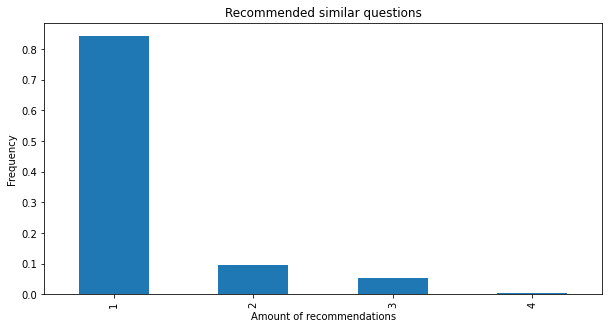

In [ ]:
plt_data = pd.Series(np.array(sim).reshape(-1))
plt_data = plt_data.groupby(plt_data).size().sort_values(ascending=False)
print('Unique values:', len(plt_data))
print(plt_data.head())
plt_data = pd.DataFrame(plt_data.groupby(plt_data).size()/len(plt_data.index))
plt_data.plot(kind='bar', legend=None, figsize=(10, 5))
plt.xlabel('Amount of recommendations')
plt.ylabel('Frequency')
plt.title('Recommended similar questions')
plt.show()

### Recommend new Question to Professionals 
For every unanswered question since 2019 we want to recommend 10 professionals, who can best answer these questions.
We get 423 experts recommended who can answer the questions best. 70% of these get only one question assigned. This is good because the questions are to be distributed over many professionals and not always the same professionals are recommended. But there is one expert who will get 42 of the 80 questions. But if we look at him, it's okay. He has been active for a very long time and has already answered over 1700 questions.

In [ ]:
%%time
weights=[1, 1, 1, 1, 1, 0]
new_questions = questions[(questions['questions_date_added'] > '2019-01-01') & (questions['questions_answers_count'] == 0)]
questions_corpus = questions[questions['questions_date_added'] > '2018-01-01']
print('count:',new_questions.shape[0])
sim = [recommend_new_question([x], questions=questions_corpus, top_questions=10, top_professionals=10, weights=weights)[0] 
       for x in new_questions['questions_full_text']]

count: 80
CPU times: user 31.7 s, sys: 157 ms, total: 31.9 s
Wall time: 31.9 s


Unique values: 428
36ff3b3666df400f956f8335cf53e09e    43
be5d23056fcb4f1287c823beec5291e1    21
a6d33c38902546849c36ea7e9e9f0870    16
6ee9c20eddbe41e890dbde50fbd63f44    13
e2b4c84bf1ca4aea9b108869692d8017    11
dtype: int64


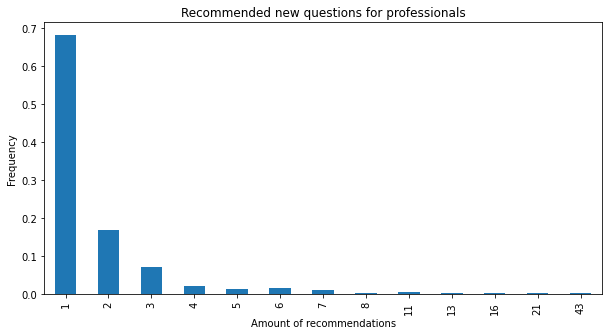

In [ ]:
plt_data = pd.Series()
for x in sim:
    plt_data = plt_data.append(pd.Series(x.index))
plt_data = plt_data.groupby(plt_data).size().sort_values(ascending=False)
print('Unique values:', len(plt_data))
print(plt_data.head())
plt_data = pd.DataFrame(plt_data.groupby(plt_data).size()/len(plt_data.index))
plt_data.plot(kind='bar', legend=None, figsize=(10, 5))
plt.xlabel('Amount of recommendations')
plt.ylabel('Frequency')
plt.title('Recommended new questions for professionals')
plt.show()

In [ ]:
professionals[professionals['professionals_id'] == '36ff3b3666df400f956f8335cf53e09e'].T

,2410
professionals_id,36ff3b3666df400f956f8335cf53e09e
professionals_location,"Cleveland, Ohio"
professionals_industry,Mental Health Care
professionals_headline,Assist with Recognizing and Developing Potential
professionals_date_joined,2015-10-19 20:56:49
professionals_time_delta_joined,1200 days 03:03:11
professionals_answers_count,1710
professionals_comments_count,317
date_last_answer,2018-10-10 10:49:06
date_first_answer,2015-10-19 21:14:32


### Recommend Questions for a Professional 
Now we want to have a look at the recommendations by e-mail. For testing we take all experts who have received a weekly e-mail since 2019-01-01. This would be 542 experts for which recommendations should be made.
As questions to answer we limit this to all questions since 2018-06-01. This is to ensure that not old questions are used (No one looks anymore at a question which is already 2 years old.) and that the calculation is faster. It needs 90 seconds to calculate this for the 542 professionals.
As a result, 620 questions were identified. Most of the questions are also recommended to several experts. One question was even identified 56 times as a recommendation. This could be, for example, if a large majority of the professionals are specialized in this domain. To validate this, we would need to take a closer look at the professionals and their answers and hashtags.

In [ ]:
%%time
weights=[3, 1, 1, 3]
professionals_email = emails[(emails['emails_date_sent'] > '2019-01-01') 
                              & (emails['emails_frequency_level'] == 'email_notification_weekly')]['emails_recipient_id'].unique()
questions_corpus = questions[questions['questions_date_added'] > '2018-09-01']
print('count:',professionals_email.shape[0])
recommendations = [recommend_questions_for_professional(x, questions=questions_corpus, weights=weights)[0] for x in professionals_email]

count: 542
CPU times: user 52.6 s, sys: 277 ms, total: 52.8 s
Wall time: 52.6 s


Unique values: 622
8a0b92f702e444509f5bc9a95695663f    56
11ce7c537cd84db0bd7840ad3ca04004    40
eb040a1a30af400ba27b25b32259e1da    37
c5001037466543bf94dc3426a9716e39    31
097474c807954152b406b4422415172a    31
dtype: int64


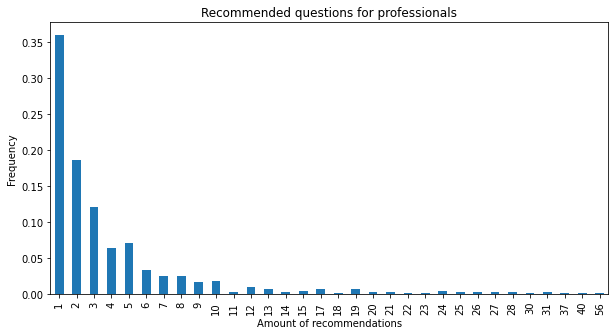

In [ ]:
plt_data = pd.Series()
for x in recommendations:
    plt_data = plt_data.append(pd.Series(x.index))
plt_data = plt_data.groupby(plt_data).size().sort_values(ascending=False)
print('Unique values:', len(plt_data))
print(plt_data.head())
plt_data = pd.DataFrame(plt_data.groupby(plt_data).size()/len(plt_data.index))
plt_data.plot(kind='bar', legend=None, figsize=(10, 5))
plt.xlabel('Amount of recommendations')
plt.ylabel('Frequency')
plt.title('Recommended questions for professionals')
plt.show()

In [ ]:
questions[questions['questions_id']=='8a0b92f702e444509f5bc9a95695663f'].T

,3434
questions_id,8a0b92f702e444509f5bc9a95695663f
questions_author_id,c5a47b4959144a6f8058e19cf5f4024b
questions_date_added,2018-09-30 16:24:57
questions_title,What can I do with a business administration d...
questions_body,#business #finance #management #accounting
questions_full_text,What can I do with a business administration d...
questions_answers_count,1
questions_first_answers,2018-10-06 01:35:46
questions_last_answers,2018-10-06 01:35:46
questions_hearts,1


### Recommend new Tags for Users
For the recommendation of the tags we use the same 542 professionals as before to test this. We will split the test to the 'recommendation by industry' and 'recommendation by answered questions'. Both require 22 seconds each for all 542 specialists. This is pretty good, because if this function will be included in the website, then it must calculate the results fast.
The top recommendations do not differ very much. For both, 'college', 'business' and 'technology' are in the top 5 recommendations. What we can still see, is that the second method 'by answered questions' is more user-oriented. This method has 655 unique tags for the recommendations, while the method 'by industry' has only 391.
The third method based on 'similar users' was not used here because it takes to long. However, as you can see in the previous chapter, it will take about 1 to 2 seconds for the calculation per professional, if all three methods are combined.

**Recommend by Industry**

In [ ]:
%%time
professionals_email = emails[(emails['emails_date_sent'] > '2019-01-01') 
                              & (emails['emails_frequency_level'] == 'email_notification_weekly')]['emails_recipient_id'].unique()
print('count:',professionals_email.shape[0])
recommendations = [recommend_tags_industry(x) for x in professionals_email]

count: 542
CPU times: user 19.3 s, sys: 43.1 ms, total: 19.4 s
Wall time: 19.4 s


Unique values: 387
college               181
management            135
business              134
project-management    100
technology             90
dtype: int64


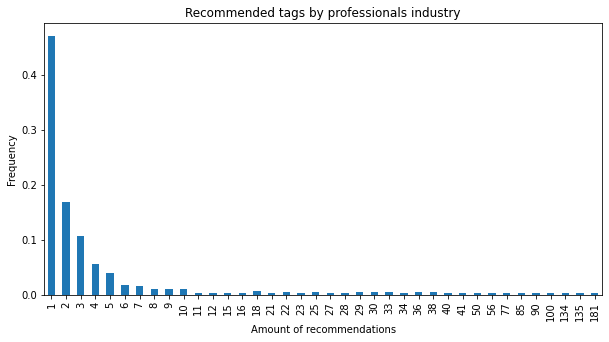

In [ ]:
plt_data = pd.Series()
for x in recommendations:
    plt_data = plt_data.append(pd.Series(x.index))
plt_data = plt_data.groupby(plt_data).size().sort_values(ascending=False)
print('Unique values:', len(plt_data))
print(plt_data.head())
plt_data = pd.DataFrame(plt_data.groupby(plt_data).size()/len(plt_data.index))
plt_data.plot(kind='bar', legend=None, figsize=(10, 5))
plt.xlabel('Amount of recommendations')
plt.ylabel('Frequency')
plt.title('Recommended tags by professionals industry')
plt.show()

**Recommendation by answered questions**

In [ ]:
%%time
professionals_email = emails[(emails['emails_date_sent'] > '2019-01-01') 
                              & (emails['emails_frequency_level'] == 'email_notification_weekly')]['emails_recipient_id'].unique()
print('count:',professionals_email.shape[0])
recommendations = [recommend_tags_questions(x) for x in professionals_email]

count: 542
CPU times: user 17.3 s, sys: 44.8 ms, total: 17.3 s
Wall time: 17.3 s


Unique values: 633
college          81
career           46
business         44
college-major    29
medicine         20
dtype: int64


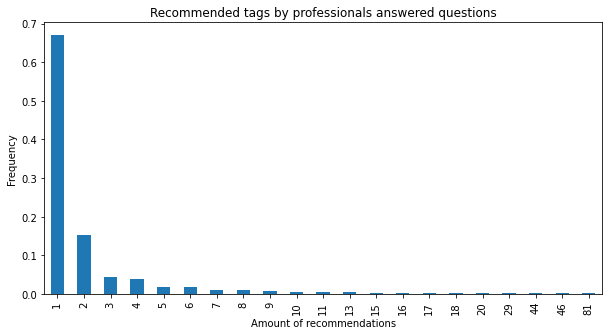

In [ ]:
plt_data = pd.Series()
for x in recommendations:
    plt_data = plt_data.append(pd.Series(x.index))
plt_data = plt_data.groupby(plt_data).size().sort_values(ascending=False)
print('Unique values:', len(plt_data))
print(plt_data.head())
plt_data = pd.DataFrame(plt_data.groupby(plt_data).size()/len(plt_data.index))
plt_data.plot(kind='bar', legend=None, figsize=(10, 5))
plt.xlabel('Amount of recommendations')
plt.ylabel('Frequency')
plt.title('Recommended tags by professionals answered questions')
plt.show()

## Further Advice

#### Model persistence:  
* **NLP Tokens:** The main component for the recommendation engine are the NLP tokens. It takes about 60 seconds to retrieve them for all questions. To avoid the need to recalculate this every time, it should be stored in the database. Only for new questions the NLP tokens have to be determined then, which makes the system faster.  
* **Topic Model:** The Topic model is the only thing we need to train if we want to use it. As already explained, this takes some time to train the model and should therefore be persisted for faster access.  

#### Ideas for additional scores:
* **previous communication:** Was there already a contact between the professional and student?  
* **location:** Prefer professionals who live in the same city or country.  
* **last login:** We already consider the 'last activity'. Additionally the 'last login' could be a nice feature.  
* **activity time:** How long and often was the professional online in the past? e.g. 5 hours in the last seven days.  
* **spam:** It should be avoided that a professional gets too many recommendations. This could overload him and demotivate him. for example it could be taken into account, how many recommendations a professional already got the last week.

#### Quality of the recommendation:  
* **No repeat of recommendations:** It should be avoided that a professional gets the same questions recommended every day. The function for calculating the recommendations expect the possible questions. These should be cleaned up to avoid spam (e.g. The question should no longer be displayed for the next seven days).   
* **Rating for a recommendation:** A good recommendation is when the professional also answer the questions. But a bad recommendation is difficult to measure. It would be helpful if a professional had a option 'don't show this question again' or something like 'I can't answer this question'. The collected information could then be used in the future to create even better recommendations for the professional.  

#### Website improvement:
* **Search for questions:** It is not immediately obvious that a student can enter an entire question in the upper search box of the website to search for similar questions. This could possibly be optimised to motivate students to search for already answered similar questions before asking the question again.  
* **Recommendation for tags:** One of the functions we have presented, recommends new tags for a professional. This recommendation can be calculated quickly and could be added to the website. This will also improve the existing solution, which makes the recommendation based on the tags.  

## Conclusion
In order to work with texts, it was important in the first step to clean the questions text and extract only the relevant information. We have used the Spacy library for this, which achieves good results with NLP on the question corpus. This could then be used to determine topics for the questions or to calculate the textual similarity between questions. The Topic model worked well on the data and delivered interesting results. This could be used, for example, to show a user what topics the question is about. But because of the time aspect more attention was paid to textual similarity.  

We have build different solutions to make recommendations for forwarding new questions to the professionals, who are best to answer them and a recommendation system for the daily/weekly e-mails with recommended questions to answers for the professionals. These work with different scoring criteria, which can be weighted differently before a final scoring is calculated. This has the advantage that we don't have a black box and can easily understand how the results were generated. Furthermore, it is very easy to add additional scoring criteria in the future and to optimize the results by weighting.  

Last but not least we have build different solutions to recommend new tags for a professional. This is especially helpful for tag-based recommendations, such as in the existing system. By using more tags, the interest of the professional can be better understood. The recommendation based on the industry of the professional is most interesting here. This allows to recommend tags even if there is not much information about a professional (cold start problem).  

For a website it is of course also important how long it takes to calculate a result. A differentiation must be made between whether it is a short-term request from the website (e.g. recommendation of a similar question) or whether it is a process that is only calculated once a day in the background (e.g. daily e-mail recommendations). For all solutions the runtimes were measured and showed good results.